## Instalación de líbrerías necesarias

In [2]:
! pip install pyreadr
! pip install fuzzywuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 5.8 MB/s eta 0:00:00


## Importación de Librerías

In [6]:
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import sklearn
# import gensim
#import pyldavis
import wordcloud
import textblob
import spacy
import pyreadr
#import textstat


## Carga de Datos

In [10]:
# Cargar los datos de SHF y SEPOMEX

# Cargamos los datos de la SHF en un OrderedDict
SHF_dic = pyreadr.read_r('01_datos_shf_estado_14.RData')

In [12]:
# Guardamos la infomación de la infomación en SHF
SHF = SHF_dic['data']

# Reservamos el nombre de colonias iniciales
SHF['settlement_original'] = SHF['settlement']

## Preprocesamiento



### Insertar un manejo de NA generalizado

In [13]:
nan_counts = SHF.isna().sum()
nan_counts

address                0
state                  0
municipality           0
zip_code               0
settlement             0
municipality_name      0
state_name             0
date_appraisal         0
code_appraisal         0
latitude               0
longitude              0
settlement_original    0
dtype: int64

In [14]:
# Mostramos los primeros registros de colonias
SHF['settlement']

rownames
1022108             LAFAYETTE
1023019       SAGRADA FAMILIA
1038522               OBLATOS
1038669               OBLATOS
1038822               OBLATOS
                  ...        
1293611    VILLA FONTANA AQUA
1295072    VILLA FONTANA AQUA
1297612    VILLA FONTANA AQUA
1484539            LA CUSPIDE
1525042          Las Ceibas 1
Name: settlement, Length: 285993, dtype: object

In [15]:
SHF['settlement'][2005:2056]

rownames
1041286                                      CUARTEL ONCEAVO
1043021                                           SAN RAFAEL
1048023                     FRACCIONAMIENTO LOMAS DE POLANCO
1227398                 VILLAS DE SAN GILBERTO ETAPA V CINCO
1236666       FRACCIONAMIENTO EL PALOMAR SECCION JOCKEY CLUB
1256653                             VALLE DE LOS ENCINOS III
1256999                                  LOS ENCINOS ETAPA 4
1258131                                           CASABLANCA
1258791                             VALLE DE LOS ENCINOS III
1259412                             VALLE DE LOS ENCINOS III
1263218                             VALLE DE LOS ENCINOS III
1265428                             VALLE DE LOS ENCINOS III
1266524                             VALLE DE LOS ENCINOS III
1266527                             VALLE DE LOS ENCINOS III
1267255                             VALLE DE LOS ENCINOS III
1268706                             VALLE DE LOS ENCINOS III
1274366        

### Manejo de números romanos y arábigos a texto

In [ ]:
# Dado que se quiere trabajar con romanos se usan mayusculas.

SHF['settlement'] = SHF['settlement'].str.upper()


In [ ]:
SHF['settlement']

rownames
1022108             LAFAYETTE
1023019       SAGRADA FAMILIA
1038522               OBLATOS
1038669               OBLATOS
1038822               OBLATOS
                  ...        
1293611    VILLA FONTANA AQUA
1295072    VILLA FONTANA AQUA
1297612    VILLA FONTANA AQUA
1484539            LA CUSPIDE
1525042          LAS CEIBAS 1
Name: settlement, Length: 285993, dtype: object

In [ ]:
!pip install num2words

In [ ]:
# Función para convertir números arábicos de dígitos a texto

import pandas as pd
import re
from num2words import num2words

def convertir_numero_a_texto(numero):
    return num2words(numero, lang='es')

def convertir_numeros_columna_a_texto(df, nombre_columna):
    # Función para buscar y reemplazar números en un texto
    def reemplazar_numeros_con_texto(texto):
        numeros = re.findall(r'\b\d+\b', str(texto)) #Limites normales de palabras, espacios comas etc.
        for num in numeros:
            texto = texto.replace(num, convertir_numero_a_texto(int(num)))
        return texto

    # Aplicar la función a la columna del DataFrame
    df[nombre_columna] = df[nombre_columna].apply(reemplazar_numeros_con_texto)

# Ejemplo de uso
# Supongamos que df es tu DataFrame y 'texto' es el nombre de la columna que quieres convertir
df = pd.DataFrame({'texto': ['Encontré 3 manzanas y 5 peras', 'Había 10 pájaros en el árbol',  "DOS SANTA FE XXXVIII"]})
convertir_numeros_columna_a_texto(df, 'texto')

# Resultado
print(df)


                                  texto
0  Encontré tres manzanas y cinco peras
1        Había diez pájaros en el árbol
2                  DOS SANTA FE XXXVIII


In [ ]:
# Convertimos la columna de interés de arábigos a texto
convertir_numeros_columna_a_texto(SHF,'settlement')
SHF

,address,state,municipality,zip_code,settlement,municipality_name,state_name,date_appraisal,code_appraisal,latitude,longitude,settlement_original
rownames,,,,,,,,,,,,
1022108,jose guadalupe zuno 2195,14,039,44150,LAFAYETTE,Guadalajara,Jalisco,2023-05-29,09067231413406952,20.670368,-103.372247,LAFAYETTE
1023019,arista 1293,14,039,44200,SAGRADA FAMILIA,Guadalajara,Jalisco,2023-05-29,09067231413407291,20.687780,-103.355140,SAGRADA FAMILIA
1038522,ramon morales 159,14,039,44700,OBLATOS,Guadalajara,Jalisco,2023-05-29,09034231410688840,20.672614,-103.326370,OBLATOS
1038669,ramon morales 159,14,039,44700,OBLATOS,Guadalajara,Jalisco,2023-05-29,09034231410688782,20.672614,-103.326370,OBLATOS
1038822,ramon morales 159,14,039,44700,OBLATOS,Guadalajara,Jalisco,2023-05-29,09034231410688800,20.672614,-103.326370,OBLATOS
...,...,...,...,...,...,...,...,...,...,...,...,...
1293611,villa napoles 199 f,14,097,45653,VILLA FONTANA AQUA,Tlajomulco de Zúñiga,Jalisco,2015-03-04,14013151410000091,20.496814,-103.349955,VILLA FONTANA AQUA
1295072,villa napoles 195 f,14,097,45653,VILLA FONTANA AQUA,Tlajomulco de Zúñiga,Jalisco,2015-03-04,14013151410000240,20.496800,-103.349714,VILLA FONTANA AQUA
1297612,villa napoles 200 f,14,097,45653,VILLA FONTANA AQUA,Tlajomulco de Zúñiga,Jalisco,2015-03-04,14013151410000300,20.497789,-103.351058,VILLA FONTANA AQUA


In [ ]:
!pip install roman

In [ ]:
# Función para convertir romanos a arábigos en dígitos

import re
from roman import fromRoman, InvalidRomanNumeralError

def romano_a_arabigo(texto):
    # Función para convertir números romanos a arábigos
    def convertir_numero_romano(romano):
        try:
            return str(fromRoman(romano))
        except InvalidRomanNumeralError:
            return romano

    # Buscar y reemplazar valores en romano en un texto
    texto = re.sub(r'\b(?:M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|IX|IV|V?I{0,3})\b', lambda x: convertir_numero_romano(x.group()), texto)
    return texto

# Ejemplo de uso
texto_ejemplo = "HACIENDA XXXVIII ONCEAVA ETAPA"
texto_convertido = romano_a_arabigo(texto_ejemplo)

print(texto_convertido)


HACIENDA 38 ONCEAVA ETAPA


In [ ]:
# Funciones combinadas
import re
from roman import fromRoman, InvalidRomanNumeralError
from num2words import num2words
import pandas as pd

def convertir_numero_a_texto(numero):
    return num2words(numero, lang='es')

def romano_a_arabigo_y_texto(texto):
    # Función para convertir números romanos a arábigos
    def convertir_numero_romano(match):
        romano = match.group()
        try:
            return str(fromRoman(romano))
        except InvalidRomanNumeralError:
            return romano

    # Buscar en el texto y reemplazar números romanos
    texto = re.sub(r'\b(?:M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|IX|IV|V?I{0,3})\b', convertir_numero_romano, texto, flags=re.IGNORECASE)

    # Función para buscar y reemplazar números en un texto
    def reemplazar_numeros_con_texto(match):
        num = match.group()
        return convertir_numero_a_texto(int(num))

    # Buscar y reemplazar valores numéricos en el texto
    texto = re.sub(r'\d+', reemplazar_numeros_con_texto, texto) #los numeros pueden estar junto otra palabra 6A registro 1317298  FRACCIONAMIENTO LAS VILLAS ETAPA 6A

    return texto

def aplicar_conversiones(df, nombre_columna):
    # Aplicar la función a la columna del DataFrame
    df[nombre_columna] = df[nombre_columna].apply(romano_a_arabigo_y_texto)

# Ejemplo de uso
df = pd.DataFrame({'texto': ['Encontré 3 manzanas y XXVI peras', 'FRACCIONAMIENTO LAS VILLAS ETAPA 6A','Había 10 pájaros en el árbol', "DOS SANTA FE XXXVIII"]})
aplicar_conversiones(df, 'texto')

# Resultado
print(df)


                                       texto
0  Encontré tres manzanas y veintiséis peras
1     FRACCIONAMIENTO LAS VILLAS ETAPA seisA
2             Había diez pájaros en el árbol
3                DOS SANTA FE treinta y ocho


In [ ]:
aplicar_conversiones(SHF, 'settlement')
SHF

,address,state,municipality,zip_code,settlement,municipality_name,state_name,date_appraisal,code_appraisal,latitude,longitude,settlement_original
rownames,,,,,,,,,,,,
1022108,jose guadalupe zuno 2195,14,039,44150,LAFAYETTE,Guadalajara,Jalisco,2023-05-29,09067231413406952,20.670368,-103.372247,LAFAYETTE
1023019,arista 1293,14,039,44200,SAGRADA FAMILIA,Guadalajara,Jalisco,2023-05-29,09067231413407291,20.687780,-103.355140,SAGRADA FAMILIA
1038522,ramon morales 159,14,039,44700,OBLATOS,Guadalajara,Jalisco,2023-05-29,09034231410688840,20.672614,-103.326370,OBLATOS
1038669,ramon morales 159,14,039,44700,OBLATOS,Guadalajara,Jalisco,2023-05-29,09034231410688782,20.672614,-103.326370,OBLATOS
1038822,ramon morales 159,14,039,44700,OBLATOS,Guadalajara,Jalisco,2023-05-29,09034231410688800,20.672614,-103.326370,OBLATOS
...,...,...,...,...,...,...,...,...,...,...,...,...
1293611,villa napoles 199 f,14,097,45653,VILLA FONTANA AQUA,Tlajomulco de Zúñiga,Jalisco,2015-03-04,14013151410000091,20.496814,-103.349955,VILLA FONTANA AQUA
1295072,villa napoles 195 f,14,097,45653,VILLA FONTANA AQUA,Tlajomulco de Zúñiga,Jalisco,2015-03-04,14013151410000240,20.496800,-103.349714,VILLA FONTANA AQUA
1297612,villa napoles 200 f,14,097,45653,VILLA FONTANA AQUA,Tlajomulco de Zúñiga,Jalisco,2015-03-04,14013151410000300,20.497789,-103.351058,VILLA FONTANA AQUA


In [ ]:
SHF['settlement'][2005:2056]

rownames
1041286                                      CUARTEL ONCEAVO
1043021                                           SAN RAFAEL
1048023                     FRACCIONAMIENTO LOMAS DE POLANCO
1227398             VILLAS DE SAN GILBERTO ETAPA cinco CINCO
1236666       FRACCIONAMIENTO EL PALOMAR SECCION JOCKEY CLUB
1256653                            VALLE DE LOS ENCINOS tres
1256999                             LOS ENCINOS ETAPA cuatro
1258131                                           CASABLANCA
1258791                            VALLE DE LOS ENCINOS tres
1259412                            VALLE DE LOS ENCINOS tres
1263218                            VALLE DE LOS ENCINOS tres
1265428                            VALLE DE LOS ENCINOS tres
1266524                            VALLE DE LOS ENCINOS tres
1266527                            VALLE DE LOS ENCINOS tres
1267255                            VALLE DE LOS ENCINOS tres
1268706                            VALLE DE LOS ENCINOS tres
1274366        

## Conversión a minúsculas

In [ ]:
# Conversión de todo a minúsculas

SHF['settlement'] = SHF['settlement'].str.lower()

## Manejo de puntuación

In [ ]:
# Manejo de signos de puntuación, puntos, comas, comillas y espacios extra

# Manejo de espacios extra
texto = "   Este es un     ejemplo    con espacios    extra.   "
texto_sin_espacios_extra = " ".join(texto.split())
texto_sin_espacios_extra

import string

# Manejo de puntuación, coma puntos, comillas
texto = "¡Hola, mundo!\" Este es un ejemplo."
texto_sin_puntuacion = texto.translate(str.maketrans("","", string.punctuation))
texto_sin_puntuacion

# Manejo de guiones (antes de espacios)
texto = "Este es un ejemplo con guiones - y también con guiones largos —."
texto_sin_guiones = texto.replace("-", " ").replace("—", " ")
texto_sin_guiones

'Este es un ejemplo con guiones   y también con guiones largos  .'

In [ ]:
import string

# Manejo de puntuación en español

def limpiar_puntuacion(texto):
    # Agregar los signos de puntuación en español
    puntuacion_espanol = string.punctuation + '¡¿'

    # Crear un diccionario de traducción para eliminar la puntuación
    translator = str.maketrans('', '', puntuacion_espanol)

    # Aplicar la traducción y eliminar la puntuación
    texto_sin_puntuacion = texto.translate(translator)

    return texto_sin_puntuacion

# Ejemplo de uso
texto = "¡Hola mundo! Este es un ejemplo con signos de ""puntuación' en español."
texto_limpiado = limpiar_puntuacion(texto)

print(texto_limpiado)


Hola mundo Este es un ejemplo con signos de puntuación en español


In [ ]:
!pip install unidecode

In [ ]:
# Integración del manejo de
from unidecode import unidecode

def quitar_acentos(texto):
    return unidecode(texto)

# Ejemplo de uso
texto_con_acentos = "¡Hola, mundo! Este es un éjemplo con ácentüs, puntos, español, etc."
texto_sin_acentos = quitar_acentos(texto_con_acentos)

print(texto_sin_acentos)


!Hola, mundo! Este es un ejemplo con acentus, puntos, espanol, etc.


In [ ]:
# integración de todo lo relacionado con puntuación

# Función que limpia todo los de puntuación y acentos del texto

def limpiar_puntuacion(texto):

    # Eliminar puntos y comas
    texto_sin_puntos = texto.replace(".", " ").replace(",", " ") # Es impotante para configuraciones decimales o combinaciones como f-25 f25 registro 95

    # Eliminar puntuación inglés
    texto_sin_puntuacion = texto_sin_puntos.translate(str.maketrans("" ,"", string.punctuation))

    # Agregar los signos de puntuación en español
    puntuacion_espanol = string.punctuation + '¡¿'

    # Crear un diccionario de traducción para eliminar la puntuación
    translator = str.maketrans('', '', puntuacion_espanol)

    # Aplicar la traducción y eliminar la puntuación
    texto_sin_puntuacion = texto_sin_puntuacion.translate(translator)

    # Eliminar guiones
    texto_sin_guiones = texto_sin_puntuacion.replace("-", " ").replace("—", " ")

    # Eliminar espacios extra
    texto_sin_espacios_extra = " ".join(texto_sin_guiones.split())


    return unidecode(texto_sin_espacios_extra) # Eliminar acentos

# Ejemplo de uso
texto = "¡Hola mundo!, Este es     un ejemplo       con signos de ""puntuación' en- Español."
texto_limpiado = limpiar_puntuacion(texto)

print(texto_limpiado)

Hola mundo Este es un ejemplo con signos de puntuacion en Espanol


In [ ]:
# Aplicar la función a la columna del df SHF

SHF['settlement'] = SHF['settlement'].apply(limpiar_puntuacion)

In [ ]:
SHF['settlement'][2005:2056]

rownames
1041286                                      cuartel onceavo
1043021                                           san rafael
1048023                     fraccionamiento lomas de polanco
1227398             villas de san gilberto etapa cinco cinco
1236666       fraccionamiento el palomar seccion jockey club
1256653                            valle de los encinos tres
1256999                             los encinos etapa cuatro
1258131                                           casablanca
1258791                            valle de los encinos tres
1259412                            valle de los encinos tres
1263218                            valle de los encinos tres
1265428                            valle de los encinos tres
1266524                            valle de los encinos tres
1266527                            valle de los encinos tres
1267255                            valle de los encinos tres
1268706                            valle de los encinos tres
1274366        

## Palabras comunes y stopwords

In [ ]:
# Asignamos a una variable global dividido por palabras (tokenización)

colonia_shf = SHF['settlement'].str.split()

colonia_shf

rownames
1022108               [lafayette]
1023019        [sagrada, familia]
1038522                 [oblatos]
1038669                 [oblatos]
1038822                 [oblatos]
                    ...          
1293611    [villa, fontana, aqua]
1295072    [villa, fontana, aqua]
1297612    [villa, fontana, aqua]
1484539             [la, cuspide]
1525042        [las, ceibas, uno]
Name: settlement, Length: 285993, dtype: object

In [ ]:
# Manejo de stopwords de español y eliminarlas del corpus principal

# Las stopwords, generalmente, nos suelen aportar valor al contexto, dependiendo del tipo de problema que tengamos.

from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('spanish'))

# Definición del corpus de los datos de colonia del SHF

corpus_stop =[]

colonia_shf = colonia_shf.values.tolist()
corpus_stop =[word for i in colonia_shf for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus_stop:
    if word in stop:
        dic[word]+=1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# diccionario de stopwords
dic

defaultdict(int,
            {'de': 62247,
             'en': 599,
             'la': 25333,
             'del': 48863,
             'uno': 8428,
             'los': 24656,
             'y': 1856,
             'yo': 879,
             'las': 15736,
             'el': 13516,
             'antes': 226,
             'a': 735,
             'como': 221,
             'somos': 443,
             'o': 741,
             'sobre': 1,
             'al': 475,
             'este': 41,
             'con': 8,
             'que': 16,
             'e': 139,
             'sin': 16,
             'para': 54,
             'lo': 7,
             'su': 7,
             'no': 16,
             'por': 4,
             'nuestra': 6,
             'entre': 1,
             'era': 2,
             'esta': 2,
             'se': 3,
             'fue': 4,
             'otra': 117,
             'son': 1,
             'es': 4,
             'estado': 2,
             'otro': 1,
             'le': 2,
             'unos': 1,
      

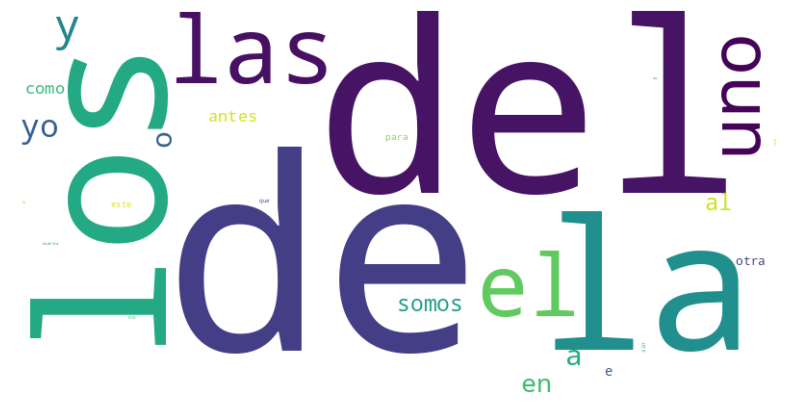

In [ ]:
from wordcloud import WordCloud

# Configurar el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dic)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<ipython-input-31-d232d9850a91>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df, palette="viridis")


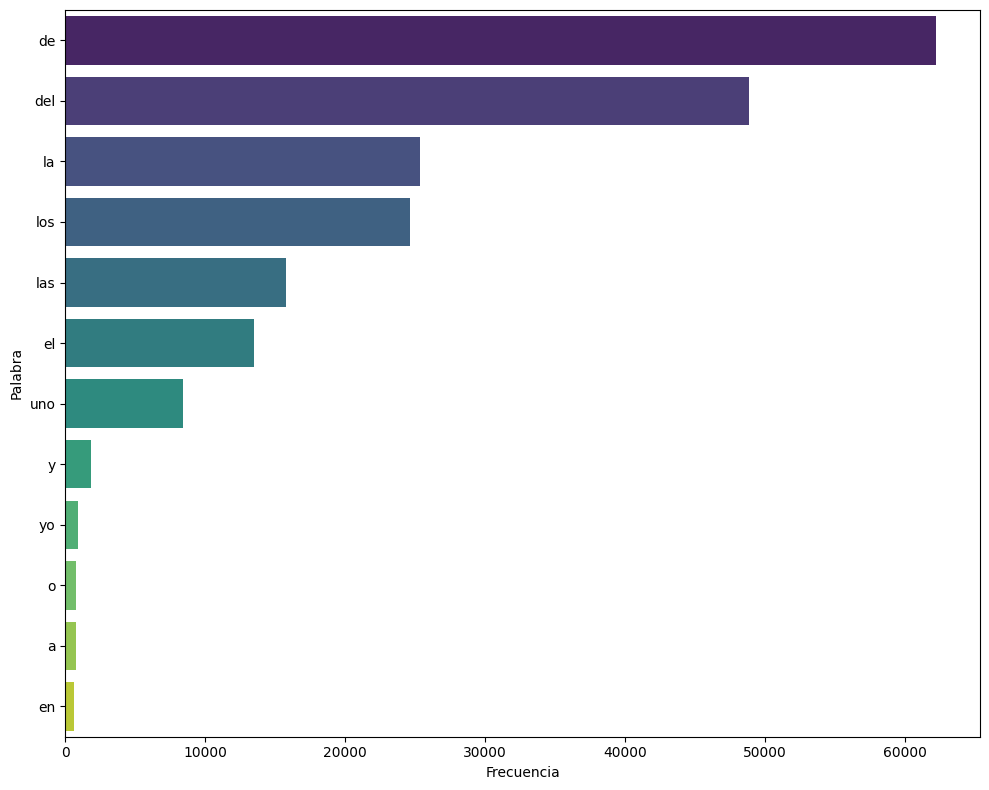

In [ ]:
# Convertir el diccionario a un DataFrame
df = pd.DataFrame(list(dic.items()), columns=['Palabra', 'Frecuencia'])

# Ordenar el DataFrame por frecuencia
df = df.sort_values(by='Frecuencia', ascending=False)

df = df[:12]

# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Frecuencia', y='Palabra', data=df, palette="viridis")

# Ajustar las etiquetas del eje y para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<ipython-input-32-3a0569abd799>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette="viridis")


<Axes: >

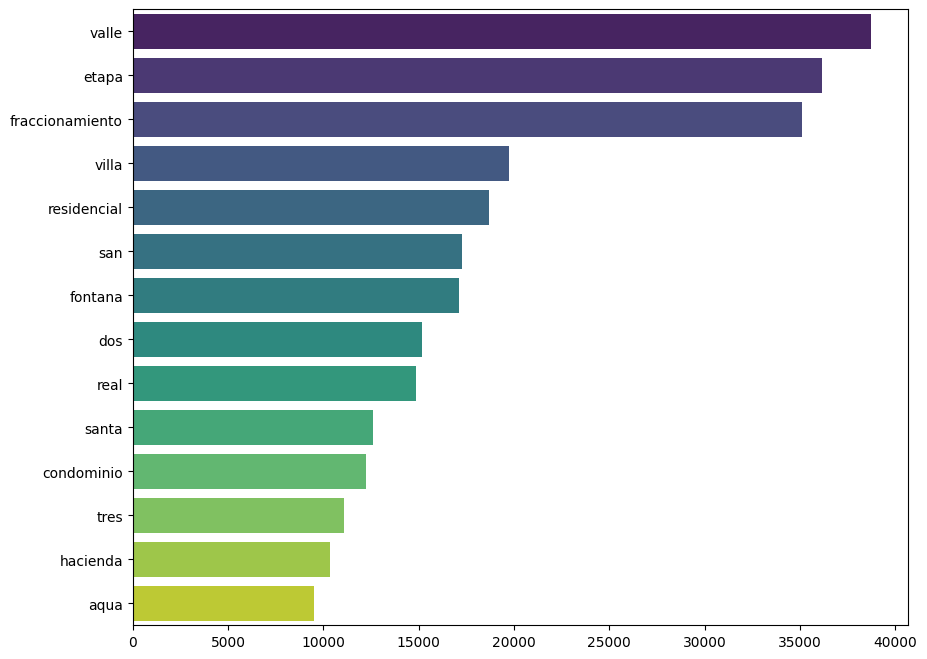

In [ ]:
from collections import Counter

# Palabras comunes sin stopwords

counter=Counter(corpus_stop)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)

# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x, palette="viridis")


In [ ]:
# Diccionario de palabras comunes x, los primeros 31 considerando los stopwords
most[0:30]

[('de', 62247),
 ('del', 48863),
 ('valle', 38717),
 ('etapa', 36156),
 ('fraccionamiento', 35114),
 ('la', 25333),
 ('los', 24656),
 ('villa', 19728),
 ('residencial', 18687),
 ('san', 17264),
 ('fontana', 17096),
 ('las', 15736),
 ('dos', 15190),
 ('real', 14839),
 ('el', 13516),
 ('santa', 12583),
 ('condominio', 12211),
 ('tres', 11082),
 ('hacienda', 10360),
 ('aqua', 9534),
 ('jardines', 9469),
 ('lomas', 9423),
 ('villas', 9084),
 ('parques', 9050),
 ('sol', 8935),
 ('bosque', 8510),
 ('cuatro', 8469),
 ('uno', 8428),
 ('colinas', 8182),
 ('diamante', 7885)]

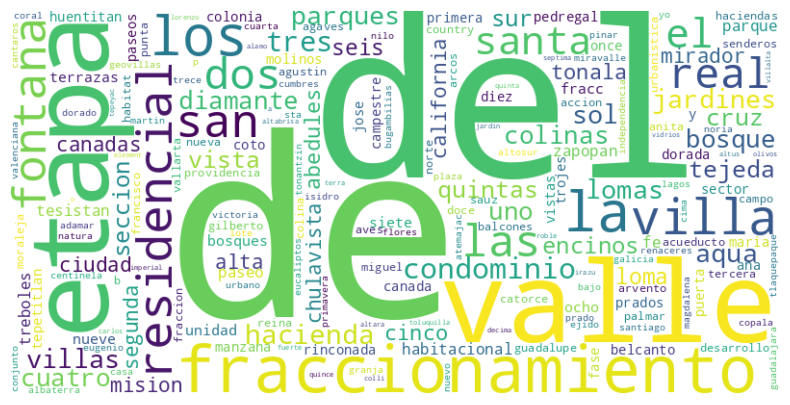

In [ ]:
# Configurar el objeto WordCloud
most_dict = dict(most)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(most_dict)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

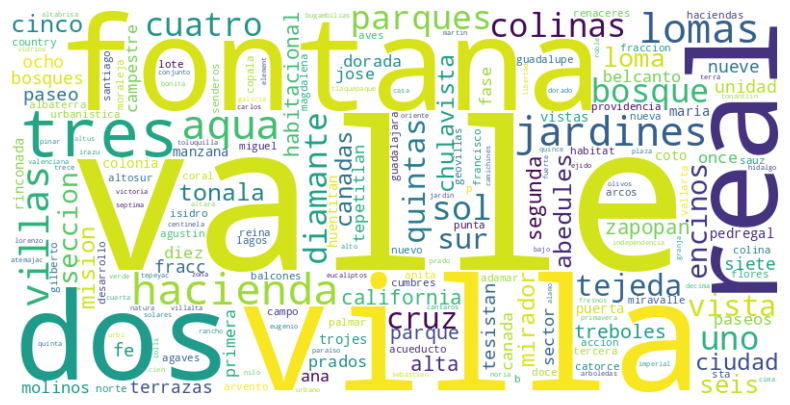

In [ ]:
# Lista de stopwords en español de NLTK
stop_words = set(stopwords.words('spanish'))

# Eliminar "somos" y "era" de la lista de stopwords
stop_words.discard("somos")
stop_words.discard("era")
stop_words.discard("eras")

# Agregar otras palabras no deseadas al conjunto de stopwords
stop_words.update(['fraccionamiento', 'condominio', 'residencial','san','residencial', 'santa', 'agua', 'etapa'])

# Filtrar el diccionario eliminando stopwords y otras palabras no deseadas
filtered_word_dict = {word: count for word, count in most_dict.items() if word.lower() not in stop_words}

filtered_word_dict.update({'uno': 8428})

# Configurar el objeto WordCloud con el diccionario filtrado
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_word_dict)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Se observa que algunas palabras comunes tiene que ver con el tipo de asentamiento, valdrá la pena revisar el comportamiento eliminando estas palabras. También se observa palabras que antes no se recolectaron como numeros en texto.

Se decide avanzar con los tipos de asentamiento dentro del nombre de colonia pero se eliminan las stopwords del los registros.

In [ ]:
colonia_shf = SHF['settlement'].str.split()

colonia_shf


rownames
1022108               [lafayette]
1023019        [sagrada, familia]
1038522                 [oblatos]
1038669                 [oblatos]
1038822                 [oblatos]
                    ...          
1293611    [villa, fontana, aqua]
1295072    [villa, fontana, aqua]
1297612    [villa, fontana, aqua]
1484539             [la, cuspide]
1525042        [las, ceibas, uno]
Name: settlement, Length: 285993, dtype: object

In [ ]:
from collections import defaultdict

# El diccionario de stopwords de SHF es dic

# Función para quitar stopwords de una lista de palabras
def quitar_stopwords(lista_palabras):
    return [palabra for palabra in lista_palabras if palabra.lower() in filtered_word_dict]

# Aplicar la función a la columna 'settlement'
colonia_shf2 = colonia_shf.apply(lambda lista: ' '.join(quitar_stopwords(lista)))

# Mostrar el DataFrame resultante
colonia_shf2


rownames
1022108             lafayette
1023019       sagrada familia
1038522               oblatos
1038669               oblatos
1038822               oblatos
                  ...        
1293611    villa fontana aqua
1295072    villa fontana aqua
1297612    villa fontana aqua
1484539               cuspide
1525042            ceibas uno
Name: settlement, Length: 285993, dtype: object

In [ ]:
# Añadir columna al dataframe

SHF['colonia_sin_stopwords'] = colonia_shf2

In [ ]:
SHF[['settlement', 'colonia_sin_stopwords']][2006:2056]

,settlement,colonia_sin_stopwords
rownames,,
1043021,san rafael,rafael
1048023,fraccionamiento lomas de polanco,lomas polanco
1227398,villas de san gilberto etapa cinco cinco,villas gilberto cinco cinco
1236666,fraccionamiento el palomar seccion jockey club,palomar seccion jockey club
1256653,valle de los encinos tres,valle encinos tres
1256999,los encinos etapa cuatro,encinos cuatro
1258131,casablanca,casablanca
1258791,valle de los encinos tres,valle encinos tres
1259412,valle de los encinos tres,valle encinos tres


In [ ]:
SHF['colonia_sin_stopwords'][2006:2056]

rownames
1043021                                               rafael
1048023                                        lomas polanco
1227398                          villas gilberto cinco cinco
1236666                          palomar seccion jockey club
1256653                                   valle encinos tres
1256999                                       encinos cuatro
1258131                                           casablanca
1258791                                   valle encinos tres
1259412                                   valle encinos tres
1263218                                   valle encinos tres
1265428                                   valle encinos tres
1266524                                   valle encinos tres
1266527                                   valle encinos tres
1267255                                   valle encinos tres
1268706                                   valle encinos tres
1274366                         villa fontana aqua fase seis
1275626        

## Valores únicos de SHF

In [ ]:
valores_unicos = SHF['settlement'].unique()
len(valores_unicos), len(SHF['settlement']), len(SHF['colonia_sin_stopwords'])

# Pasamos de 285,993 registros a 29,485 registros únicos sin preprocesamiento (ver R)
# Pasamos de 29,485 a 21,810 registros únicos con el preprocesamiento.

(21810, 285993, 285993)

## Datos SEPOMEX

In [ ]:
# Cargamos el excel de SEPOMEX
SEPOMEX = pd.read_excel('sepomex_jalisco_23012024.xls', sheet_name= 1)

In [ ]:
nan_counts = SEPOMEX.isna().sum()
nan_counts


d_codigo               0
d_asenta               0
d_tipo_asenta          0
D_mnpio                0
d_estado               0
d_ciudad            2889
d_CP                   0
c_estado               0
c_oficina              0
c_CP                6072
c_tipo_asenta          0
c_mnpio                0
id_asenta_cpcons       0
d_zona                 0
c_cve_ciudad        2889
dtype: int64

In [ ]:
SEPOMEX.head()

,d_codigo,d_asenta,d_tipo_asenta,D_mnpio,d_estado,d_ciudad,d_CP,c_estado,c_oficina,c_CP,c_tipo_asenta,c_mnpio,id_asenta_cpcons,d_zona,c_cve_ciudad
0,44100,Guadalajara Centro,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,3,Urbano,3.0
1,44110,Vallarta Poniente,Fraccionamiento,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,21,39,5,Urbano,3.0
2,44130,Arcos Vallarta,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,7,Urbano,3.0
3,44130,Arcos,Fraccionamiento,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,21,39,200,Urbano,3.0
4,44140,Obrera Centro,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,8,Urbano,3.0


In [ ]:
colonia_sepomex = SEPOMEX['d_asenta']
SEPOMEX['d_asenta_original'] = SEPOMEX['d_asenta']

In [ ]:
# Dado que se quiere trabajar con romanos se usan mayusculas.

SEPOMEX['d_asenta'] = SEPOMEX['d_asenta'].str.upper()

In [ ]:
SEPOMEX['d_asenta'][680:696]

680               CASA GRANDE
681        REAL DE VALDEPEÑAS
682         REAL DEL CAMICHIN
683        BOSQUES DE ZAPOPAN
684         BOSQUE VALDEPEÑAS
685          HACIENDA DEL SOL
686        PUNTA VALDEPEÑAS 2
687        PUNTA VALDEPEÑAS 1
688    CAÑADAS DE SAN LORENZO
689     ALTAVISTA RESIDENCIAL
690    PRADERAS DEL CENTINELA
691    CANTERAS DEL CENTINELA
692               ZOI CAÑADAS
693     REAL DE VALDEPEÑAS II
694        VITANA RESIDENCIAL
695              LAS VENTANAS
Name: d_asenta, dtype: object

In [ ]:
# Convertimos la columna de interés de arábigos a texto
# Se hace primero esto porque la función romano a texto no acepta números
convertir_numeros_columna_a_texto(SEPOMEX,'d_asenta')
SEPOMEX

,d_codigo,d_asenta,d_tipo_asenta,D_mnpio,d_estado,d_ciudad,d_CP,c_estado,c_oficina,c_CP,c_tipo_asenta,c_mnpio,id_asenta_cpcons,d_zona,c_cve_ciudad,d_asenta_original
0,44100,GUADALAJARA CENTRO,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,3,Urbano,3.0,Guadalajara Centro
1,44110,VALLARTA PONIENTE,Fraccionamiento,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,21,39,5,Urbano,3.0,Vallarta Poniente
2,44130,ARCOS VALLARTA,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,7,Urbano,3.0,Arcos Vallarta
3,44130,ARCOS,Fraccionamiento,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,21,39,200,Urbano,3.0,Arcos
4,44140,OBRERA CENTRO,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,8,Urbano,3.0,Obrera Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,49990,VILLA MORELOS (EL CARRIZO),Ranchería,Santa María del Oro,Jalisco,NaN,49541,14,49541,NaN,29,56,1,Rural,NaN,Villa Morelos (El Carrizo)
6068,49990,LOS PLÁTANOS,Colonia,Santa María del Oro,Jalisco,NaN,49541,14,49541,NaN,9,56,4873,Rural,NaN,Los Plátanos
6069,49994,ZIPOCO,Ranchería,Santa María del Oro,Jalisco,NaN,49541,14,49541,NaN,29,56,4900,Rural,NaN,Zipoco
6070,49994,LAS PAROTAS,Ranchería,Santa María del Oro,Jalisco,NaN,49541,14,49541,NaN,29,56,4906,Rural,NaN,Las Parotas


In [ ]:
# Manejo de números romanos y arábigos a texto
aplicar_conversiones(SEPOMEX, 'd_asenta')
SEPOMEX

,d_codigo,d_asenta,d_tipo_asenta,D_mnpio,d_estado,d_ciudad,d_CP,c_estado,c_oficina,c_CP,c_tipo_asenta,c_mnpio,id_asenta_cpcons,d_zona,c_cve_ciudad,d_asenta_original
0,44100,GUADALAJARA CENTRO,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,3,Urbano,3.0,Guadalajara Centro
1,44110,VALLARTA PONIENTE,Fraccionamiento,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,21,39,5,Urbano,3.0,Vallarta Poniente
2,44130,ARCOS VALLARTA,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,7,Urbano,3.0,Arcos Vallarta
3,44130,ARCOS,Fraccionamiento,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,21,39,200,Urbano,3.0,Arcos
4,44140,OBRERA CENTRO,Colonia,Guadalajara,Jalisco,Guadalajara,44101,14,44101,NaN,9,39,8,Urbano,3.0,Obrera Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,49990,VILLA MORELOS (EL CARRIZO),Ranchería,Santa María del Oro,Jalisco,NaN,49541,14,49541,NaN,29,56,1,Rural,NaN,Villa Morelos (El Carrizo)
6068,49990,LOS PLÁTANOS,Colonia,Santa María del Oro,Jalisco,NaN,49541,14,49541,NaN,9,56,4873,Rural,NaN,Los Plátanos
6069,49994,ZIPOCO,Ranchería,Santa María del Oro,Jalisco,NaN,49541,14,49541,NaN,29,56,4900,Rural,NaN,Zipoco
6070,49994,LAS PAROTAS,Ranchería,Santa María del Oro,Jalisco,NaN,49541,14,49541,NaN,29,56,4906,Rural,NaN,Las Parotas


In [ ]:
# Algunos registros significativos

SEPOMEX['d_asenta'][680:696]

680               CASA GRANDE
681        REAL DE VALDEPEÑAS
682         REAL DEL CAMICHIN
683        BOSQUES DE ZAPOPAN
684         BOSQUE VALDEPEÑAS
685          HACIENDA DEL SOL
686      PUNTA VALDEPEÑAS dos
687      PUNTA VALDEPEÑAS uno
688    CAÑADAS DE SAN LORENZO
689     ALTAVISTA RESIDENCIAL
690    PRADERAS DEL CENTINELA
691    CANTERAS DEL CENTINELA
692               ZOI CAÑADAS
693    REAL DE VALDEPEÑAS dos
694        VITANA RESIDENCIAL
695              LAS VENTANAS
Name: d_asenta, dtype: object

In [ ]:
SEPOMEX['d_asenta'][720:736] # Comportamiento de paréntesis

720                             LOS ÁLAMOS
721    LAS CAÑADAS (BOSQUES DE SAN ISIDRO)
722                             SAN ISIDRO
723                  COLINAS DEL CENTINELA
724                  MIRADOR DE SAN ISIDRO
725                    HACIENDAS DEL VALLE
726                     VILLAS DEL MIRADOR
727                    VALLE DE SAN ISIDRO
728       HACIENDAS DEL VALLE dosA SECCIÓN
729                      MISIÓN DEL BOSQUE
730                  PARQUES DEL CENTINELA
731                 RESIDENCIAL SAN ISIDRO
732                   MIRADOR DE LA CAÑADA
733                    RANCHO EL CENTINELA
734                   MISIÓN DE SAN ISIDRO
735                          LOS ALMENDROS
Name: d_asenta, dtype: object

In [ ]:
# Conversión de todo a minúsculas

SEPOMEX['d_asenta'] = SEPOMEX['d_asenta'].str.lower()

In [ ]:
# Aplicar la función de puntuación a la columna del df SEPOMEX

SEPOMEX['d_asenta'] = SEPOMEX['d_asenta'].apply(limpiar_puntuacion)
SEPOMEX['d_asenta'][720:736]

720                           los alamos
721    las canadas bosques de san isidro
722                           san isidro
723                colinas del centinela
724                mirador de san isidro
725                  haciendas del valle
726                   villas del mirador
727                  valle de san isidro
728     haciendas del valle dosa seccion
729                    mision del bosque
730                parques del centinela
731               residencial san isidro
732                 mirador de la canada
733                  rancho el centinela
734                 mision de san isidro
735                        los almendros
Name: d_asenta, dtype: object

In [ ]:
# Asignamos a una variable global dividido por palabras

colonia_sepomex = SEPOMEX['d_asenta'].str.split()

colonia_sepomex

0               [guadalajara, centro]
1                [vallarta, poniente]
2                   [arcos, vallarta]
3                             [arcos]
4                    [obrera, centro]
                    ...              
6067    [villa, morelos, el, carrizo]
6068                  [los, platanos]
6069                         [zipoco]
6070                   [las, parotas]
6071        [abasolo, la, otra, casa]
Name: d_asenta, Length: 6072, dtype: object

In [ ]:
# Manejo de stopwords de español y eliminarlas del corpus principal

# Las stopwords, generalmente, nos suelen aportar valor al contexto, dependiendo del tipo de problema que tengamos.

# Definición del corpus de los datos de colonia del SEPOMEX

corpus_stop_SEPOMEX =[]

colonia_sepomex = colonia_sepomex.values.tolist()
corpus_stop_SEPOMEX =[word for i in colonia_sepomex for word in i]

from collections import defaultdict
dic_SEPOMEX = defaultdict(int)
for word in corpus_stop_SEPOMEX:
    if word in stop:
        dic_SEPOMEX[word]+=1

In [ ]:
# diccionario de stopwords
dic_SEPOMEX

defaultdict(int,
            {'el': 859,
             'de': 1108,
             'del': 494,
             'la': 895,
             'no': 2,
             'las': 300,
             'y': 17,
             'los': 455,
             'uno': 27,
             'o': 3,
             'nuestra': 1,
             'por': 1,
             'a': 4,
             'sin': 1,
             'al': 2,
             'en': 1,
             'lo': 2,
             'eras': 1,
             'era': 1,
             'e': 1,
             'otra': 1})

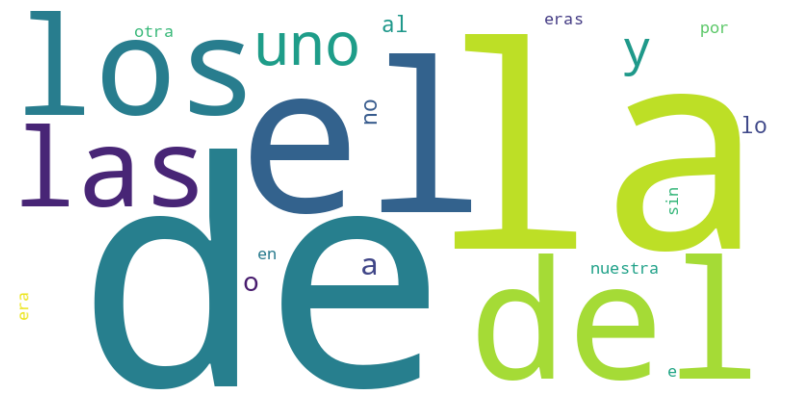

In [ ]:
# Configurar el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dic_SEPOMEX)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<ipython-input-58-5fc7bec88dd1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df, palette="viridis")


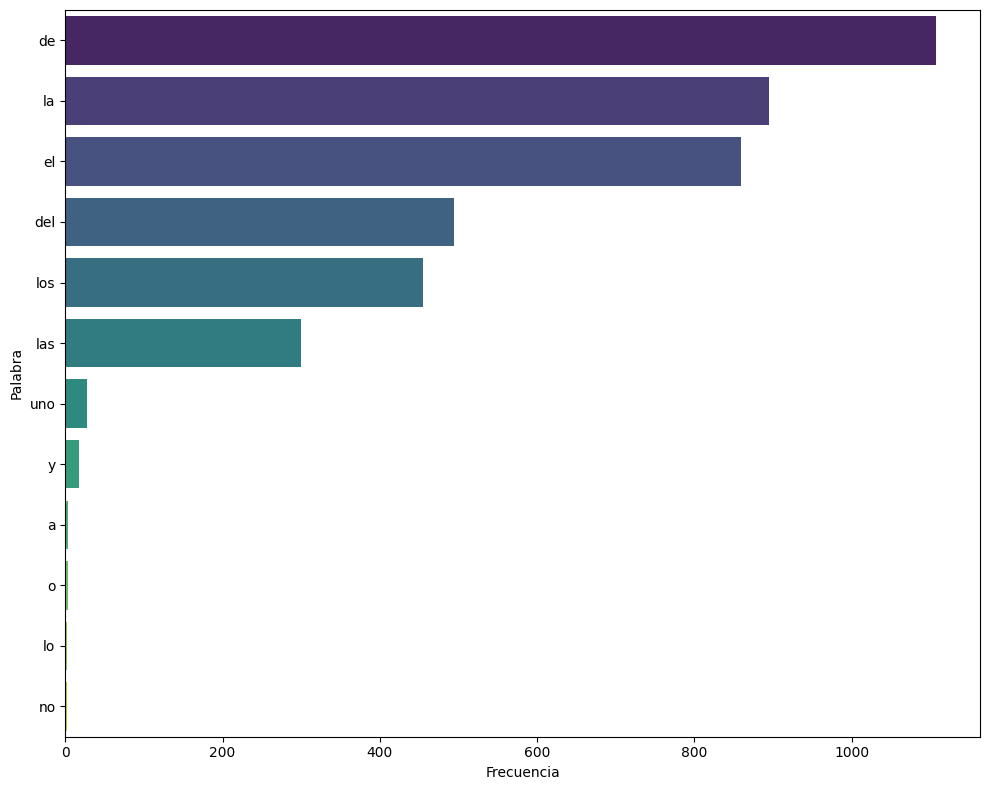

In [ ]:
# Convertir el diccionario a un DataFrame
df = pd.DataFrame(list(dic_SEPOMEX.items()), columns=['Palabra', 'Frecuencia'])

# Ordenar el DataFrame por frecuencia
df = df.sort_values(by='Frecuencia', ascending=False)

df = df[:12]

# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Frecuencia', y='Palabra', data=df, palette="viridis")

# Ajustar las etiquetas del eje y para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<ipython-input-59-3b183304f35f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette="viridis")


<Axes: >

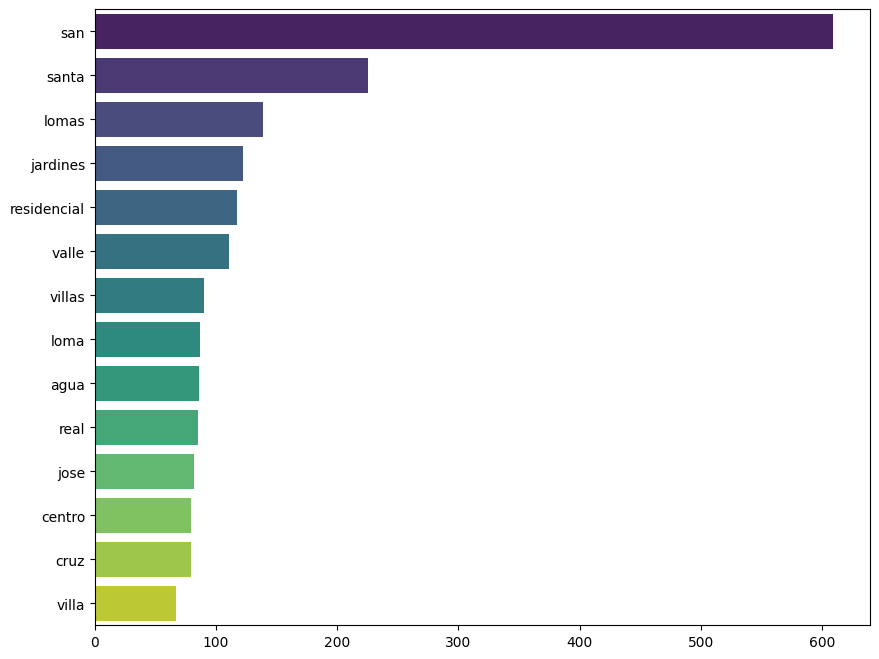

In [ ]:
from collections import Counter

# Palabras comunes sin stopwords

counter2=Counter(corpus_stop_SEPOMEX)
most2=counter2.most_common()

x, y= [], []
for word,count in most2[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)

# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x, palette="viridis")


In [ ]:
# Diccionario de palabras comunes x, los primeros 31 considerando los stopwords
most2[0:30]

[('de', 1108),
 ('la', 895),
 ('el', 859),
 ('san', 609),
 ('del', 494),
 ('los', 455),
 ('las', 300),
 ('santa', 225),
 ('lomas', 139),
 ('jardines', 122),
 ('residencial', 117),
 ('valle', 111),
 ('villas', 90),
 ('loma', 87),
 ('agua', 86),
 ('real', 85),
 ('jose', 82),
 ('centro', 79),
 ('cruz', 79),
 ('villa', 67),
 ('miguel', 63),
 ('rinconada', 61),
 ('rancho', 59),
 ('guadalupe', 58),
 ('juan', 57),
 ('antonio', 54),
 ('hacienda', 54),
 ('sol', 53),
 ('francisco', 53),
 ('dos', 50)]

Se observa que algunas palabras comunes tiene que ver con el tipo de asentamiento, valdrá la pena revisar el comportamiento eliminando estas palabras. También se observa palabras que antes no se recolectaron como numeros en texto.

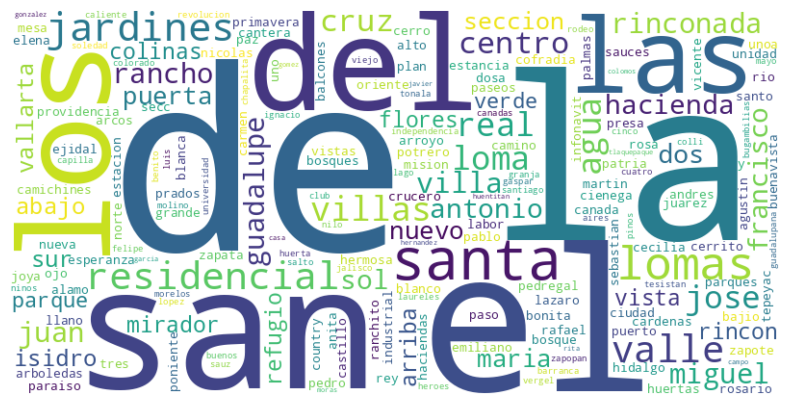

In [ ]:
# Configurar el objeto WordCloud
most_dict = dict(most2)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(most_dict)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Se decide avanzar con los tipos de asentamiento dentro del nombre de colonia pero se eliminan las stopwords del los registros.

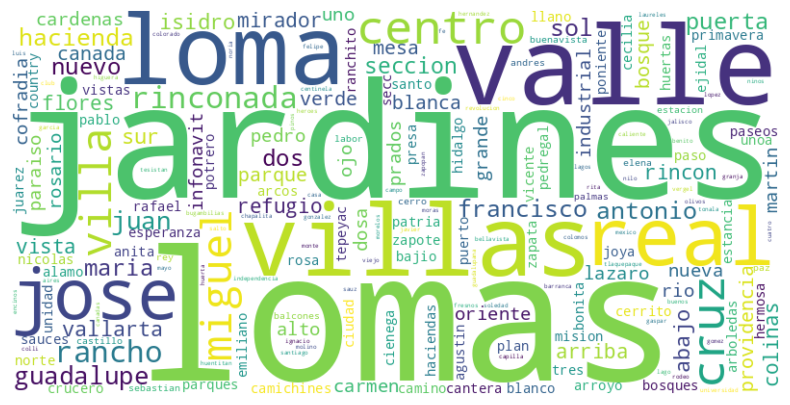

In [ ]:
# Lista de stopwords en español de NLTK
stop_words = set(stopwords.words('spanish'))

# Eliminar "somos" y "era" de la lista de stopwords
stop_words.discard("somos")
stop_words.discard("era")
stop_words.discard("eras")

# Agregar otras palabras no deseadas al conjunto de stopwords
stop_words.update(['fraccionamiento', 'condominio', 'residencial','san','residencial', 'santa', 'agua', 'etapa'])


# Filtrar el diccionario eliminando stopwords y otras palabras no deseadas
filtered_word_dict = {word: count for word, count in most_dict.items() if word.lower() not in stop_words}

filtered_word_dict.update({'uno': 27})

# Configurar el objeto WordCloud con el diccionario filtrado
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_word_dict)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
colonia_sepomex = SEPOMEX['d_asenta'].str.split()

colonia_sepomex


0               [guadalajara, centro]
1                [vallarta, poniente]
2                   [arcos, vallarta]
3                             [arcos]
4                    [obrera, centro]
                    ...              
6067    [villa, morelos, el, carrizo]
6068                  [los, platanos]
6069                         [zipoco]
6070                   [las, parotas]
6071        [abasolo, la, otra, casa]
Name: d_asenta, Length: 6072, dtype: object

In [ ]:
from collections import defaultdict

# El diccionario de stopwords de SEPOMEX es dic_SEPOMEX

# Función para quitar stopwords de una lista de palabras
def quitar_stopwords(lista_palabras):
    return [palabra for palabra in lista_palabras if palabra.lower() in filtered_word_dict]

# Aplicar la función a la columna 'settlement'
colonia_sepomex2 = colonia_sepomex.apply(lambda lista: ' '.join(quitar_stopwords(lista)))

# Mostrar el DataFrame resultante
colonia_sepomex2


0          guadalajara centro
1           vallarta poniente
2              arcos vallarta
3                       arcos
4               obrera centro
                ...          
6067    villa morelos carrizo
6068                 platanos
6069                   zipoco
6070                  parotas
6071             abasolo casa
Name: d_asenta, Length: 6072, dtype: object

In [ ]:
# Añadir columna al dataframe

SEPOMEX['colonia_sin_stopwords_SEPOMEX'] =  colonia_sepomex2

In [ ]:
#SEPOMEX[['d_asenta', 'colonia_sin_stopwords_SEPOMEX']][54:56]
SEPOMEX[['d_asenta', 'colonia_sin_stopwords_SEPOMEX']][339:349]

,d_asenta,colonia_sin_stopwords_SEPOMEX
339,tetlan uno,tetlan uno
340,tetlan dos,tetlan dos
341,villas de la presa,villas presa
342,villas del nilo,villas nilo
343,florencia,florencia
344,parques de san pedro,parques pedro
345,popular hornos,popular hornos
346,el barro,barro
347,las piedrotas,piedrotas
348,vistas del nilo,vistas nilo


In [ ]:
valores_unicos_SEPOMEX = SEPOMEX['d_asenta'].unique()
len(valores_unicos_SEPOMEX), len(SEPOMEX['d_asenta']), len(SEPOMEX['colonia_sin_stopwords_SEPOMEX'])

# Pasamos de 6,072 registros a 4667 registros únicos sin preprocesamiento (ver R)
# Pasamos de 4667 a 4611 registros únicos con el preprocesamiento

(4611, 6072, 6072)

In [ ]:
# Número de valores únicos en settlement de SHF por número de valores únicos en d_asente de SEPOMEX
21810*4611

#100,565,910

100565910

In [ ]:
# Número de valores totales en settlement de SHF por número de valores totales en d_asente de SEPOMEX
285993*6072

#1,736,549,496

1736549496

## Tokenizar y stemming (opcional)

In [ ]:
import nltk
nltk.download('punkt') # Para el stemming

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


# Función para limpiar y tokenizar el texto
def token_stemming(text):

    # Eliminar caracteres no alfabéticos y números
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Tokenización
    tokens = word_tokenize(text)

    # Stemming (opcional)
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(token) for token in tokens]

    # Unir tokens en un string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [ ]:
# Aplicar la función de preprocesamiento a la columna 'settlement' de SHF
SHF['cleaned_settlement'] = SHF['colonia_sin_stopwords'].apply(token_stemming)

# Mostrar el DataFrame resultante
print(SHF[['settlement', 'colonia_sin_stopwords','cleaned_settlement']])

                  settlement colonia_sin_stopwords cleaned_settlement
rownames                                                             
1022108            lafayette             lafayette           lafayett
1023019      sagrada familia       sagrada familia        sagr famili
1038522              oblatos               oblatos              oblat
1038669              oblatos               oblatos              oblat
1038822              oblatos               oblatos              oblat
...                      ...                   ...                ...
1293611   villa fontana aqua    villa fontana aqua    vill fontan aqu
1295072   villa fontana aqua    villa fontana aqua    vill fontan aqu
1297612   villa fontana aqua    villa fontana aqua    vill fontan aqu
1484539           la cuspide               cuspide             cuspid
1525042       las ceibas uno            ceibas uno           ceib uno

[285993 rows x 3 columns]


In [ ]:
# Aplicar la función de preprocesamiento a la columna 'd_asenta' de SEPOMEX
SEPOMEX['cleaned_d_asenta'] = SEPOMEX['colonia_sin_stopwords_SEPOMEX'].apply(token_stemming)

# Mostrar el DataFrame resultante
print(SEPOMEX[['d_asenta', 'colonia_sin_stopwords_SEPOMEX', 'cleaned_d_asenta']])

                      d_asenta colonia_sin_stopwords_SEPOMEX  \
0           guadalajara centro            guadalajara centro   
1            vallarta poniente             vallarta poniente   
2               arcos vallarta                arcos vallarta   
3                        arcos                         arcos   
4                obrera centro                 obrera centro   
...                        ...                           ...   
6067  villa morelos el carrizo         villa morelos carrizo   
6068              los platanos                      platanos   
6069                    zipoco                        zipoco   
6070               las parotas                       parotas   
6071      abasolo la otra casa                  abasolo casa   

       cleaned_d_asenta  
0        guadalaj centr  
1       vallart ponient  
2         arcos vallart  
3                 arcos  
4           obrer centr  
...                 ...  
6067  vill morel carriz  
6068             platan

In [ ]:
SEPOMEX.to_csv('SEPOMEX_clean.csv', index=False)
SHF.to_csv('SHF_clean.csv', index=False)

In [ ]:
SEPOMEX['d_asenta_original'] # Aqui si conserva bien los acentos

0               Guadalajara Centro
1                Vallarta Poniente
2                   Arcos Vallarta
3                            Arcos
4                    Obrera Centro
                   ...            
6067    Villa Morelos (El Carrizo)
6068                  Los Plátanos
6069                        Zipoco
6070                   Las Parotas
6071        Abasolo (La Otra Casa)
Name: d_asenta_original, Length: 6072, dtype: object

In [ ]:
SHF['settlement']

rownames
1022108             lafayette
1023019       sagrada familia
1038522               oblatos
1038669               oblatos
1038822               oblatos
                  ...        
1293611    villa fontana aqua
1295072    villa fontana aqua
1297612    villa fontana aqua
1484539            la cuspide
1525042        las ceibas uno
Name: settlement, Length: 285993, dtype: object

# Aplicación de la distancia de edición, fuzzy y también normalizada.

# Muestra simple

In [ ]:
# Especifica el tamaño de la muestra que deseas, por ejemplo, el 10% del conjunto de datos
porcentaje_muestra = 0.10
tamaño_muestra = int(len(SHF) * porcentaje_muestra)

# Obtén la muestra aleatoria y conserva el índice del DataFrame original
SHF_muestra = SHF.sample(n=tamaño_muestra, random_state=42)  # Puedes ajustar el valor de random_state para reproducibilidad


In [ ]:
SHF_muestra

,address,state,municipality,zip_code,settlement,municipality_name,state_name,date_appraisal,code_appraisal,latitude,longitude,settlement_original,colonia_sin_stopwords,cleaned_settlement
rownames,,,,,,,,,,,,,,
1466023,avenida e,14,120,45134,la cantera habitat integral funo,Zapopan,Jalisco,2018-12-10,09074181410841860,20.788333,-103.416417,LA CANTERA HABITAT INTEGRAL F1,cantera habitat integral funo,canter habitat integral fun
1303180,villa lisboa,14,097,45653,villa fontana aqua,Tlajomulco de Zúñiga,Jalisco,2015-09-02,14013151410114550,20.490614,-103.345530,VILLA FONTANA AQUA,villa fontana aqua,vill fontan aqu
1251113,boulevard senderos de monte verde en la calle ...,14,097,45646,fraccionamiento senderos de monte verde etapa ...,Tlajomulco de Zúñiga,Jalisco,2022-06-23,19011221411636230,20.515628,-103.492716,Fraccionamiento Senderos de Monte Verde Etapa IV,senderos monte verde cuatro,sender mont verd cuatr
1347002,circuito valle grande,14,098,45601,residencial valle del sur,San Pedro Tlaquepaque,Jalisco,2017-01-25,09057171410031470,20.596110,-103.404646,RESIDENCIAL VALLE DEL SUR,valle sur,vall sur
1498590,paraiso 2549,14,120,45200,jardines la magdalena,Zapopan,Jalisco,2018-09-27,14009181410251161,20.807706,-103.451983,JARDINES LA MAGDALENA,jardines magdalena,jardin magdalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042003,andador alfonso toro,14,039,44760,unidad habitacional el zalate,Guadalajara,Jalisco,2017-12-12,14003171410116030,20.681632,-103.274467,Unidad Habitacional El Zalate,unidad habitacional zalate,unid habitacional zalat
1489443,av. valle de ameca,14,120,45200,valle del sol,Zapopan,Jalisco,2016-02-25,14013161410218880,20.851738,-103.421204,VALLE DEL SOL,valle sol,vall sol
1273505,via hercules,14,097,45653,las luces dos,Tlajomulco de Zúñiga,Jalisco,2016-10-21,14006161410989110,20.521472,-103.381172,LAS LUCES II,luces dos,luc dos


## Distancia de edición simple

Para cada registro del SHF asignarle un top 3 de las posibles opciones para homologar del SEPOMEX.  

Para cada codigo postal asignarle un top 3 del más cercano junto con su distancia

In [ ]:
import pandas as pd
#SHF = pd.read_csv('SHF_clean (1).csv', sep = ',')
#SEPOMEX = pd.read_csv('SEPOMEX_clean (1).csv', sep = ',')

<ipython-input-80-d9ed47b5bfff>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(SEPOMEX, x='d_codigo', y='d_zona', inner='box', palette='Dark2')


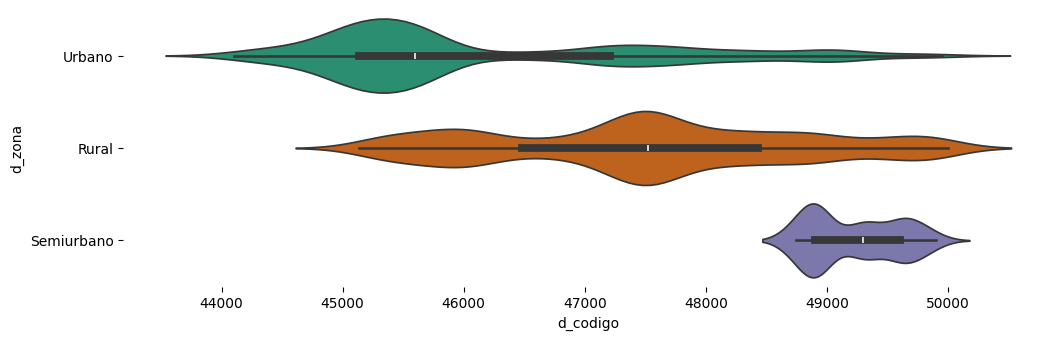

In [ ]:
# @title d_zona vs d_codigo

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(SEPOMEX['d_zona'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(SEPOMEX, x='d_codigo', y='d_zona', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
nan_counts = SEPOMEX.isna().sum()
nan_counts
#SEPOMEX[SEPOMEX['cleaned_d_asenta'].isna()]

d_codigo                            0
d_asenta                            0
d_tipo_asenta                       0
D_mnpio                             0
d_estado                            0
d_ciudad                         2889
d_CP                                0
c_estado                            0
c_oficina                           0
c_CP                             6072
c_tipo_asenta                       0
c_mnpio                             0
id_asenta_cpcons                    0
d_zona                              0
c_cve_ciudad                     2889
d_asenta_original                   0
colonia_sin_stopwords_SEPOMEX       0
cleaned_d_asenta                    0
dtype: int64

In [ ]:
nan_counts = SHF.isna().sum()
nan_counts
#SHF[SHF['settlement'].isna()]

address                  0
state                    0
municipality             0
zip_code                 0
settlement               0
municipality_name        0
state_name               0
date_appraisal           0
code_appraisal           0
latitude                 0
longitude                0
settlement_original      0
colonia_sin_stopwords    0
cleaned_settlement       0
dtype: int64

# Codigo postal
Tengo dos DF uno llamado SEPOMEX con las variables de d_asenta (colonia), d_codigo (CP), colonia_sin_stopwords_SEPOMEX y cleaned_d_asenta que es el stemming, por otro lado tengo el DF SHF con las variables settlement (colonia), zip_code (CP), colonia_sin_stopwords y cleaned_settlement que es el stemming, requiero saber que porcentaje de CP del SHF no están en el CP del SEPOMEX



In [ ]:
# Calcula el conjunto de códigos postales únicos en cada DataFrame
SHF['zip_code'] = SHF['zip_code'].astype(str)
SEPOMEX['d_codigo'] = SEPOMEX['d_codigo'].astype(str)

cp_shf_unique = set(SHF['zip_code'])
cp_sepomex_unique = set(SEPOMEX['d_codigo'])

# Encuentra los códigos postales en df_shf que no están en df_sepomex
cp_not_in_sepomex = cp_shf_unique - cp_sepomex_unique

# Calcula el porcentaje
porcentaje_no_encontrados = len(cp_not_in_sepomex) / len(cp_shf_unique) * 100

print(f"Porcentaje de CP del SHF no presentes en el SEPOMEX: {porcentaje_no_encontrados:.2f}%")

Porcentaje de CP del SHF no presentes en el SEPOMEX: 1.11%


In [ ]:
# Porcentaje de colonias en SEPOMEX, exactitud

# Convertir las columnas de colonias a tipo de dato str
SHF['settlement'] = SHF['settlement'].astype(str)
SEPOMEX['d_asenta'] = SEPOMEX['d_asenta'].astype(str)

# Calcula el conjunto de colonias únicas en cada DataFrame
colonias_shf_unique = set(SHF['settlement'])
colonias_sepomex_unique = set(SEPOMEX['d_asenta'])

# Encuentra las colonias en df_shf que no están en df_sepomex
colonias_not_in_sepomex = colonias_shf_unique - colonias_sepomex_unique

# Calcula el porcentaje
porcentaje_no_encontrados = len(colonias_not_in_sepomex) / len(colonias_shf_unique) * 100

print(f"Porcentaje de colonias del SHF no presentes en el SEPOMEX: {porcentaje_no_encontrados:.2f}%")

Porcentaje de colonias del SHF no presentes en el SEPOMEX: 93.17%


In [ ]:
# Porcentaje de colonias en SEPOMEX, exactitud

# Convertir las columnas de colonias a tipo de dato str
SHF['cleaned_settlement'] = SHF['cleaned_settlement'].astype(str)
SEPOMEX['cleaned_d_asenta'] = SEPOMEX['cleaned_d_asenta'].astype(str)

# Calcula el conjunto de colonias únicas en cada DataFrame
colonias_shf_unique = set(SHF['cleaned_settlement'])
colonias_sepomex_unique = set(SEPOMEX['cleaned_d_asenta'])

# Encuentra las colonias en df_shf que no están en df_sepomex
colonias_not_in_sepomex = colonias_shf_unique - colonias_sepomex_unique

# Calcula el porcentaje
porcentaje_no_encontrados = len(colonias_not_in_sepomex) / len(colonias_shf_unique) * 100

print(f"Porcentaje de colonias del SHF no presentes en el SEPOMEX: {porcentaje_no_encontrados:.2f}%")

Porcentaje de colonias del SHF no presentes en el SEPOMEX: 90.76%


In [ ]:
! pip install python-Levenshtein


Calcular matriz de distancia de edición de settlement vs d_asenta y normalizar.


In [ ]:
import editdistance
import Levenshtein
editdistance.eval("lista1", "listas2"), Levenshtein.distance("lista1", "listas2")

(2, 2)

In [ ]:
help(editdistance)

Help on package editdistance:

NAME
    editdistance

PACKAGE CONTENTS
    bycython

FUNCTIONS
    distance(*args, **kwargs)
        "An alias to eval
    
    eval(...)

DATA
    __all__ = ('eval', 'distance')

FILE
    /usr/local/lib/python3.10/dist-packages/editdistance/__init__.py




In [ ]:
help(Levenshtein.distance)

Help on function distance in module Levenshtein:

distance(s1, s2, *, weights=(1, 1, 1), processor=None, score_cutoff=None, score_hint=None)
    Calculates the minimum number of insertions, deletions, and substitutions
    required to change one sequence into the other according to Levenshtein with custom
    costs for insertion, deletion and substitution
    
    Parameters
    ----------
    s1 : Sequence[Hashable]
        First string to compare.
    s2 : Sequence[Hashable]
        Second string to compare.
    weights : Tuple[int, int, int] or None, optional
        The weights for the three operations in the form
        (insertion, deletion, substitution). Default is (1, 1, 1),
        which gives all three operations a weight of 1.
    processor: callable, optional
        Optional callable that is used to preprocess the strings before
        comparing them. Default is None, which deactivates this behaviour.
    score_cutoff : int, optional
        Maximum distance between s1 a

In [ ]:
# Definir una función para calcular la distancia de edición entre dos listas
def calcular_distancia_edicion(lista1, lista2):
    return Levenshtein.distance(lista1, lista2)

# Definir el tamaño del lote
#tamano_lote = 1000

# Dividir los DataFrames en lotes
lotes_SHF = [SHF_muestra[i:i + tamano_lote] for i in range(0, len(SHF_muestra), tamano_lote)]
lotes_SEPOMEX = [SEPOMEX[i:i + tamano_lote] for i in range(0, len(SEPOMEX), tamano_lote)]

# Inicializar una lista para almacenar los resultados
resultados_distancia = []

# Calcular la distancia de edición para cada lote
for lote_SHF, lote_SEPOMEX in zip(lotes_SHF, lotes_SEPOMEX):
    for _, row_SHF in lote_SHF.iterrows():
        for _, row_SEPOMEX in lote_SEPOMEX.iterrows():
            distancia = calcular_distancia_edicion(row_SHF['settlement'], row_SEPOMEX['d_asenta'])
            resultados_distancia.append({
                'settlement': row_SHF['settlement'],
                'd_asenta': row_SEPOMEX['d_asenta'],
                'distancia_edicion': distancia
            })

# Convertir la lista de resultados a DataFrame
matriz_distancia = pd.DataFrame(resultados_distancia)

# Mostrar el DataFrame de la matriz de distancia
print(matriz_distancia)

NameError: name 'tamano_lote' is not defined

In [ ]:
SHF_subset = SHF_muestra.drop_duplicates(subset=['settlement']).head(100)

In [ ]:
# Definimos una función para calcular la distancia de Levenshtein
def calcular_distancia_levenshtein(str1, str2):
    return Levenshtein.distance(str1, str2)

# Inicializamos una lista para almacenar los resultados
resultados_distancia = []

# Iteramos sobre cada fila de SHF y todas las filas de SEPOMEX
for _, row_SHF in SHF_subset.iterrows():
    for _, row_SEPOMEX in SEPOMEX.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        distancia = calcular_distancia_levenshtein(row_SHF['settlement'], row_SEPOMEX['d_asenta'])

        # Guardamos los resultados en la lista
        resultados_distancia.append({
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'distancia_levenshtein': distancia
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia = pd.DataFrame(resultados_distancia)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia)

                          settlement_SHF          d_asenta_SEPOMEX  \
0       la cantera habitat integral funo        guadalajara centro   
1       la cantera habitat integral funo         vallarta poniente   
2       la cantera habitat integral funo            arcos vallarta   
3       la cantera habitat integral funo                     arcos   
4       la cantera habitat integral funo             obrera centro   
...                                  ...                       ...   
607195         valle de los encinos tres  villa morelos el carrizo   
607196         valle de los encinos tres              los platanos   
607197         valle de los encinos tres                    zipoco   
607198         valle de los encinos tres               las parotas   
607199         valle de los encinos tres      abasolo la otra casa   

                   settlement_original           d_asenta_original  \
0       LA CANTERA HABITAT INTEGRAL F1          Guadalajara Centro   
1       LA CANTERA 

In [ ]:
50*6072

303600

In [ ]:
matriz_distancia['distancia_levenshtein'].max()

73

In [ ]:
matriz_distancia['distancia_levenshtein_normalizada'] = matriz_distancia['distancia_levenshtein']/ matriz_distancia['distancia_levenshtein'].max()

In [ ]:
matriz_distancia['porcentaje_similitud'] = 1-matriz_distancia['distancia_levenshtein_normalizada']

In [ ]:
matriz_distancia.sort_values('distancia_levenshtein')[0:10]

,settlement_SHF,d_asenta_SEPOMEX,settlement_original,d_asenta_original,distancia_levenshtein,distancia_levenshtein_normalizada,porcentaje_similitud
200531,arcos sur,arcos sur,ARCOS SUR,Arcos Sur,0,0.0,1.0
323958,real del sol,real del sol,REAL DEL SOL,Real del Sol,0,0.0,1.0
106859,colinas del valle,colinas del valle,COLINAS DEL VALLE,Colinas Del Valle,0,0.0,1.0
462272,jardines del valle,jardines del valle,JARDINES DEL VALLE,Jardines Del Valle,0,0.0,1.0
585038,sendero real,sendero real,SENDERO REAL,Sendero Real,0,0.0,1.0
462641,jardines del valle,jardines del valle,JARDINES DEL VALLE,Jardines del Valle,0,0.0,1.0
304035,ciudad granja,ciudad granja,CIUDAD GRANJA,Ciudad Granja,0,0.0,1.0
92808,salvador portillo lopez,salvador portillo lopez,SALVADOR PORTILLO LOPEZ,Salvador Portillo López,0,0.0,1.0
262806,lomas de tlaquepaque,lomas de tlaquepaque,LOMAS DE TLAQUEPAQUE,Lomas de Tlaquepaque,0,0.0,1.0
354319,quintas del valle,quintas del valle,QUINTAS DEL VALLE,Quintas del Valle,0,0.0,1.0


In [ ]:
matriz_distancia_ordenada = matriz_distancia.sort_values(by='distancia_levenshtein')
SHF_subset_menores_distancias_unicas = matriz_distancia_ordenada.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas

,settlement_SHF,d_asenta_SEPOMEX,settlement_original,d_asenta_original,distancia_levenshtein,distancia_levenshtein_normalizada,porcentaje_similitud
200531,arcos sur,arcos sur,ARCOS SUR,Arcos Sur,0,0.000000,1.000000
323958,real del sol,real del sol,REAL DEL SOL,Real del Sol,0,0.000000,1.000000
106859,colinas del valle,colinas del valle,COLINAS DEL VALLE,Colinas Del Valle,0,0.000000,1.000000
462272,jardines del valle,jardines del valle,JARDINES DEL VALLE,Jardines Del Valle,0,0.000000,1.000000
585038,sendero real,sendero real,SENDERO REAL,Sendero Real,0,0.000000,1.000000
...,...,...,...,...,...,...,...
14192,fraccionamiento senderos de monte verde etapa ...,senderos de monte verde,Fraccionamiento Senderos de Monte Verde Etapa IV,Senderos de Monte Verde,29,0.397260,0.602740
564865,accion urbanistica denominada mirador del bosq...,rinconada del bosque,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,Rinconada del Bosque,33,0.452055,0.547945
186205,fraccionamiento valle de los encinos tres etap...,fraccion los cajones el ranchito,Fraccionamiento Valle de los Encinos III Etapa 18,Fracción los Cajones (El Ranchito),35,0.479452,0.520548
299234,fraccionamiento el campestre residencial condo...,camichines residencial unora seccion,Fraccionamiento El Campestre Residencial Condo...,Camichines Residencial 1ra. Sección,39,0.534247,0.465753


In [ ]:
SHF_subset_menores_distancias_unicas[0:100]

,settlement_SHF,d_asenta_SEPOMEX,settlement_original,d_asenta_original,distancia_levenshtein,distancia_levenshtein_normalizada,porcentaje_similitud
200531,arcos sur,arcos sur,ARCOS SUR,Arcos Sur,0,0.000000,1.000000
323958,real del sol,real del sol,REAL DEL SOL,Real del Sol,0,0.000000,1.000000
106859,colinas del valle,colinas del valle,COLINAS DEL VALLE,Colinas Del Valle,0,0.000000,1.000000
462272,jardines del valle,jardines del valle,JARDINES DEL VALLE,Jardines Del Valle,0,0.000000,1.000000
585038,sendero real,sendero real,SENDERO REAL,Sendero Real,0,0.000000,1.000000
...,...,...,...,...,...,...,...
14192,fraccionamiento senderos de monte verde etapa ...,senderos de monte verde,Fraccionamiento Senderos de Monte Verde Etapa IV,Senderos de Monte Verde,29,0.397260,0.602740
564865,accion urbanistica denominada mirador del bosq...,rinconada del bosque,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,Rinconada del Bosque,33,0.452055,0.547945
186205,fraccionamiento valle de los encinos tres etap...,fraccion los cajones el ranchito,Fraccionamiento Valle de los Encinos III Etapa 18,Fracción los Cajones (El Ranchito),35,0.479452,0.520548
299234,fraccionamiento el campestre residencial condo...,camichines residencial unora seccion,Fraccionamiento El Campestre Residencial Condo...,Camichines Residencial 1ra. Sección,39,0.534247,0.465753


In [ ]:
len(SHF_subset_menores_distancias_unicas)

100

Lo mismo pero para la columna sin stopwords y mostrar las columnas originales

In [ ]:
#SHF['colonia_sin_stopwords'] = SHF['colonia_sin_stopwords'].astype(str)
#SEPOMEX['colonia_sin_stopwords_SEPOMEX'] = SEPOMEX['colonia_sin_stopwords_SEPOMEX'].astype(str)

In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia2 = []

# Iteramos sobre cada fila de SHF y todas las filas de SEPOMEX
for _, row_SHF in SHF_subset.iterrows():
    for _, row_SEPOMEX in SEPOMEX.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        distancia = calcular_distancia_levenshtein(row_SHF['colonia_sin_stopwords'], row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'])

        # Guardamos los resultados en la lista
        resultados_distancia2.append({
            'colonia_sin_stopwords_SHF': row_SHF['colonia_sin_stopwords'],
            'colonia_sin_stopwords_SEPOMEX': row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_levenshtein': distancia
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia2 = pd.DataFrame(resultados_distancia2)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia2)

            colonia_sin_stopwords_SHF colonia_sin_stopwords_SEPOMEX  \
0       cantera habitat integral funo            guadalajara centro   
1       cantera habitat integral funo             vallarta poniente   
2       cantera habitat integral funo                arcos vallarta   
3       cantera habitat integral funo                         arcos   
4       cantera habitat integral funo                 obrera centro   
...                               ...                           ...   
607195             valle encinos tres         villa morelos carrizo   
607196             valle encinos tres                      platanos   
607197             valle encinos tres                        zipoco   
607198             valle encinos tres                       parotas   
607199             valle encinos tres                  abasolo casa   

                   settlement_original           d_asenta_original  \
0       LA CANTERA HABITAT INTEGRAL F1          Guadalajara Centro   
1      

In [ ]:
matriz_distancia2['distancia_levenshtein'].max()

56

In [ ]:
matriz_distancia2['distancia_levenshtein_normalizada'] = matriz_distancia2['distancia_levenshtein']/ matriz_distancia2['distancia_levenshtein'].max()

In [ ]:
matriz_distancia2['porcentaje_similitud'] = 1-matriz_distancia2['distancia_levenshtein_normalizada']

In [ ]:
matriz_distancia2.sort_values('distancia_levenshtein')[45:60]

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,distancia_levenshtein_normalizada,porcentaje_similitud
455908,arcos guadalupe,arcos guadalupe,ARCOS DE GUADALUPE,Arcos de Guadalupe,arcos de guadalupe,arcos de guadalupe,0,0.0,1.0
8175,villa fontana aqua,villa fontana aqua,VILLA FONTANA AQUA,Villa Fontana Aqua,villa fontana aqua,villa fontana aqua,0,0.0,1.0
433050,tlajomulco centro,tlajomulco centro,TLAJOMULCO CENTRO,Tlajomulco Centro,tlajomulco centro,tlajomulco centro,0,0.0,1.0
293203,huertas,huertas,LAS HUERTAS,Las Huertas,las huertas,las huertas,0,0.0,1.0
443672,palmas,palmas,LAS PALMAS,Las Palmas,las palmas,las palmas,0,0.0,1.0
339769,loma bonita,loma bonita,Fraccionamiento Residencial Loma Bonita,Loma Bonita,fraccionamiento residencial loma bonita,loma bonita,0,0.0,1.0
571243,valle real,valle real,Valle Real,Valle Real,valle real,valle real,0,0.0,1.0
445377,palmas,palmas,LAS PALMAS,Las Palmas,las palmas,las palmas,0,0.0,1.0
413188,rinconada valle,rinconada valle,RINCONADA DEL VALLE,Rinconada del Valle,rinconada del valle,rinconada del valle,0,0.0,1.0
287490,valle tejeda,valle tejeda,VALLE DE TEJEDA,Valle de Tejeda,valle de tejeda,valle de tejeda,0,0.0,1.0


In [ ]:
matriz_distancia_ordenada2 = matriz_distancia2.sort_values(by='distancia_levenshtein')
SHF_subset_menores_distancias_unicas2 = matriz_distancia_ordenada2.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas2

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,distancia_levenshtein_normalizada,porcentaje_similitud
92808,salvador portillo lopez,salvador portillo lopez,SALVADOR PORTILLO LOPEZ,Salvador Portillo López,salvador portillo lopez,salvador portillo lopez,0,0.000000,1.000000
553181,villa verona,villa verona,VILLA VERONA,Villa Verona,villa verona,villa verona,0,0.000000,1.000000
323958,real sol,real sol,REAL DEL SOL,Real del Sol,real del sol,real del sol,0,0.000000,1.000000
533012,jardines,jardines,Residencial Jardines,Jardines,residencial jardines,jardines,0,0.000000,1.000000
336215,loma bonita,loma bonita,Fraccionamiento Residencial Loma Bonita,Loma Bonita,fraccionamiento residencial loma bonita,loma bonita,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
486041,beatriz hernandez sector libertad,beatriz hernandez,BEATRIZ HERNANDEZ / SECTOR LIBERTAD,Beatriz Hernández,beatriz hernandez sector libertad,beatriz hernandez,16,0.285714,0.714286
398300,fracc bosque real bosque real,rinconada valle real,"""FRACC. BOSQUE REAL, CONDOMINIO BOSQUE REAL""",Rinconada Valle Real,fracc bosque real condominio bosque real,rinconada valle real,17,0.303571,0.696429
34818,desarrollo habitacional altavista unoa,habitacional andres,DESARROLLO HABITACIONAL ALTAVISTA 1-A,Habitacional San Andrés,desarrollo habitacional altavista unoa,habitacional san andres,23,0.410714,0.589286
564865,accion urbanistica denominada mirador bosque dos,rinconada bosque,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,Rinconada del Bosque,accion urbanistica denominada mirador del bosq...,rinconada del bosque,33,0.589286,0.410714


Lo mismo pero con la columna stemming

In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia3 = []

# Iteramos sobre cada fila de SHF y todas las filas de SEPOMEX
for _, row_SHF in SHF_subset.iterrows():
    for _, row_SEPOMEX in SEPOMEX.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        distancia = calcular_distancia_levenshtein(row_SHF['cleaned_settlement'], row_SEPOMEX['cleaned_d_asenta'])

        # Guardamos los resultados en la lista
        resultados_distancia3.append({
            'cleaned_settlement_SHF': row_SHF['cleaned_settlement'],
            'cleaned_d_asenta_SEPOMEX': row_SEPOMEX['cleaned_d_asenta'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_levenshtein': distancia
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia3 = pd.DataFrame(resultados_distancia3)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia3)

             cleaned_settlement_SHF cleaned_d_asenta_SEPOMEX  \
0       canter habitat integral fun           guadalaj centr   
1       canter habitat integral fun          vallart ponient   
2       canter habitat integral fun            arcos vallart   
3       canter habitat integral fun                    arcos   
4       canter habitat integral fun              obrer centr   
...                             ...                      ...   
607195              vall encin tres        vill morel carriz   
607196              vall encin tres                   platan   
607197              vall encin tres                    zipoc   
607198              vall encin tres                    parot   
607199              vall encin tres               abasol cas   

                   settlement_original           d_asenta_original  \
0       LA CANTERA HABITAT INTEGRAL F1          Guadalajara Centro   
1       LA CANTERA HABITAT INTEGRAL F1           Vallarta Poniente   
2       LA CANTERA HA

In [ ]:
matriz_distancia3['distancia_levenshtein'].max()

50

In [ ]:
matriz_distancia3['distancia_levenshtein_normalizada'] = matriz_distancia3['distancia_levenshtein']/ matriz_distancia3['distancia_levenshtein'].max()

In [ ]:
matriz_distancia3['porcentaje_similitud'] = 1-matriz_distancia3['distancia_levenshtein_normalizada']

In [ ]:
matriz_distancia3.sort_values('distancia_levenshtein')[2045:2060]

,cleaned_settlement_SHF,cleaned_d_asenta_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,distancia_levenshtein_normalizada,porcentaje_similitud
531203,jardin,sabin,Residencial Jardines,El Sabino,residencial jardines,el sabino,3,0.06,0.94
446045,palm,sauz,LAS PALMAS,Sauza,las palmas,sauza,3,0.06,0.94
257756,vill,nicol,LAS VILLAS,San Nicolás,las villas,san nicolas,3,0.06,0.94
71899,troj,flor,LAS TROJES,Las Flores,las trojes,las flores,3,0.06,0.94
260244,vill,pinal,LAS VILLAS,El Piñal,las villas,el pinal,3,0.06,0.94
255774,vill,tigr,LAS VILLAS,El Tigre,las villas,el tigre,3,0.06,0.94
479618,adam,can,Fraccionamiento Adamar,La Cañada,fraccionamiento adamar,la canada,3,0.06,0.94
473856,adam,arand,Fraccionamiento Adamar,Arandas,fraccionamiento adamar,arandas,3,0.06,0.94
72469,troj,tecu,LAS TROJES,El Tecuán,las trojes,el tecuan,3,0.06,0.94
479621,adam,quem,Fraccionamiento Adamar,El Quemado,fraccionamiento adamar,el quemado,3,0.06,0.94


In [ ]:
matriz_distancia_ordenada3 = matriz_distancia3.sort_values(by='distancia_levenshtein')
SHF_subset_menores_distancias_unicas3 = matriz_distancia_ordenada3.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas3

,cleaned_settlement_SHF,cleaned_d_asenta_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,distancia_levenshtein_normalizada,porcentaje_similitud
291723,huert,huert,LAS HUERTAS,Las Huertas,las huertas,las huertas,0,0.00,1.00
413188,rincon vall,rincon vall,RINCONADA DEL VALLE,Rinconada del Valle,rinconada del valle,rinconada del valle,0,0.00,1.00
110848,jardin haciend,jardin haciend,JARDINES DE LA HACIENDA E,Jardines de La Hacienda,jardines de la hacienda e,jardines de la hacienda,0,0.00,1.00
224759,monumental,monumental,MONUMENTAL,Monumental,monumental,monumental,0,0.00,1.00
287490,vall tejed,vall tejed,VALLE DE TEJEDA,Valle de Tejeda,valle de tejeda,valle de tejeda,0,0.00,1.00
...,...,...,...,...,...,...,...,...,...
486041,beatriz hernandez sector libert,beatriz hernandez,BEATRIZ HERNANDEZ / SECTOR LIBERTAD,Beatriz Hernández,beatriz hernandez sector libertad,beatriz hernandez,14,0.28,0.72
396717,fracc bosqu real bosqu real,arbol bosqu anit,"""FRACC. BOSQUE REAL, CONDOMINIO BOSQUE REAL""",Arbolada Bosques de Santa Anita,fracc bosque real condominio bosque real,arbolada bosques de santa anita,16,0.32,0.68
34818,desarroll habitacional altav uno,habitacional andres,DESARROLLO HABITACIONAL ALTAVISTA 1-A,Habitacional San Andrés,desarrollo habitacional altavista unoa,habitacional san andres,18,0.36,0.64
566773,accion urbanist denomin mirador bosqu dos,colin real benit villasenor,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,Colina Real (Benito Villaseñor),accion urbanistica denominada mirador del bosq...,colina real benito villasenor,28,0.56,0.44


Ejercicio usando CP

Para incorporar la restricción de búsqueda por código postal, se ha de modificar el bucle para que solo calcule las distancias entre las colonias del SHF y las colonias del SEPOMEX que tienen el mismo código postal.

In [ ]:
SEPOMEX.columns

Index(['d_codigo', 'd_asenta', 'd_tipo_asenta', 'D_mnpio', 'd_estado',
       'd_ciudad', 'd_CP', 'c_estado', 'c_oficina', 'c_CP', 'c_tipo_asenta',
       'c_mnpio', 'id_asenta_cpcons', 'd_zona', 'c_cve_ciudad',
       'd_asenta_original', 'colonia_sin_stopwords_SEPOMEX',
       'cleaned_d_asenta'],
      dtype='object')

In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia4 = []

# Iteramos sobre cada fila de SHF con el código postal deseado
for _, row_SHF in SHF_subset.iterrows():
    # Filtramos SEPOMEX para que solo contenga filas con el mismo código postal
    SEPOMEX_cp_filtrado = SEPOMEX[SEPOMEX['d_codigo'] == row_SHF['zip_code']]

    # Iteramos sobre todas las filas de SEPOMEX con el mismo código postal
    for _, row_SEPOMEX in SEPOMEX_cp_filtrado.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        distancia = calcular_distancia_levenshtein(row_SHF['colonia_sin_stopwords'], row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'])

        # Guardamos los resultados en la lista
        resultados_distancia4.append({
            'colonia_sin_stopwords_SHF': row_SHF['colonia_sin_stopwords'],
            'colonia_sin_stopwords_SEPOMEX': row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_levenshtein': distancia,
            'zip_code': row_SHF['zip_code'],
            'd_codigo': row_SEPOMEX['d_codigo']
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia4 = pd.DataFrame(resultados_distancia4)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia4)


          colonia_sin_stopwords_SHF colonia_sin_stopwords_SEPOMEX  \
0     cantera habitat integral funo                      moraleja   
1     cantera habitat integral funo                real cantabria   
2     cantera habitat integral funo              campestre robles   
3     cantera habitat integral funo                      guayabos   
4     cantera habitat integral funo                      madeiras   
...                             ...                           ...   
2644             valle encinos tres               arcos sebastian   
2645             valle encinos tres               casas sebastian   
2646             valle encinos tres                        miguel   
2647             valle encinos tres                 colinas roble   
2648             valle encinos tres                       encinos   

                 settlement_original           d_asenta_original  \
0     LA CANTERA HABITAT INTEGRAL F1                 La Moraleja   
1     LA CANTERA HABITAT INTEGRAL F

In [ ]:
50*6072

303600

In [ ]:
matriz_distancia4['distancia_levenshtein'].max()

53

In [ ]:
matriz_distancia4['distancia_levenshtein_normalizada'] = matriz_distancia4['distancia_levenshtein']/ matriz_distancia4['distancia_levenshtein'].max()

In [ ]:
matriz_distancia4['porcentaje_similitud'] = 1-matriz_distancia4['distancia_levenshtein_normalizada']

In [ ]:
matriz_distancia4.sort_values('distancia_levenshtein')[1045:1060]

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,zip_code,d_codigo,distancia_levenshtein_normalizada,porcentaje_similitud
2602,parque aves,mirador bosque,PARQUE DE LAS AVES,Mirador del Bosque,parque de las aves,mirador del bosque,12,45200,45200,0.226415,0.773585
2544,parque aves,campestre palomas,PARQUE DE LAS AVES,Campestre Las Palomas,parque de las aves,campestre las palomas,12,45200,45200,0.226415,0.773585
2297,vista sur,lomas pedregal,VISTA SUR,Lomas del Pedregal,vista sur,lomas del pedregal,12,45640,45640,0.226415,0.773585
1743,rinconada valle,toscana,RINCONADA DEL VALLE,La Toscana,rinconada del valle,la toscana,12,45136,45136,0.226415,0.773585
2293,vista sur,rinconada auroras,VISTA SUR,Rinconada las Auroras,vista sur,rinconada las auroras,12,45640,45640,0.226415,0.773585
2294,vista sur,valle tlajomulco,VISTA SUR,Valle de Tlajomulco,vista sur,valle de tlajomulco,12,45640,45640,0.226415,0.773585
2640,valle encinos tres,villas eden,VALLE DE LOS ENCINOS III,Villas del Edén,valle de los encinos tres,villas del eden,12,45650,45650,0.226415,0.773585
2333,banus,habitat millan,BANUS RESIDENCIAL,Hábitat San Millán,banus residencial,habitat san millan,12,45645,45645,0.226415,0.773585
1809,tlajomulco centro,tecolote,TLAJOMULCO CENTRO,El Tecolote,tlajomulco centro,el tecolote,12,45640,45640,0.226415,0.773585
1753,rinconada valle,jardin real,RINCONADA DEL VALLE,Jardín Real,rinconada del valle,jardin real,12,45136,45136,0.226415,0.773585


In [ ]:
matriz_distancia_ordenada4 = matriz_distancia4.sort_values(by='distancia_levenshtein')
SHF_subset_menores_distancias_unicas4 = matriz_distancia_ordenada4.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas4

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,zip_code,d_codigo,distancia_levenshtein_normalizada,porcentaje_similitud
667,vista zapopan,vista zapopan,VISTA ZAPOPAN,Vista Zapopan,vista zapopan,vista zapopan,0,45200,45200,0.000000,1.000000
1344,ciudad granja,ciudad granja,CIUDAD GRANJA,Ciudad Granja,ciudad granja,ciudad granja,0,45010,45010,0.000000,1.000000
419,villa fontana diamante,villa fontana diamante,VILLA FONTANA DIAMANTE,Villa Fontana Diamante,villa fontana diamante,villa fontana diamante,0,45200,45200,0.000000,1.000000
1852,palmas,palmas,LAS PALMAS,Las Palmas,las palmas,las palmas,0,45654,45654,0.000000,1.000000
574,salvador portillo lopez,salvador portillo lopez,SALVADOR PORTILLO LOPEZ,Salvador Portillo López,salvador portillo lopez,salvador portillo lopez,0,45580,45580,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1719,fracc bosque real bosque real,bosque real,"""FRACC. BOSQUE REAL, CONDOMINIO BOSQUE REAL""",Bosque Real,fracc bosque real condominio bosque real,bosque real,18,45645,45645,0.339623,0.660377
9,cantera habitat integral funo,altaterra dos,LA CANTERA HABITAT INTEGRAL F1,Altaterra II,la cantera habitat integral funo,altaterra dos,21,45134,45134,0.396226,0.603774
167,desarrollo habitacional altavista unoa,real valdepenas dos,DESARROLLO HABITACIONAL ALTAVISTA 1-A,Real de Valdepeñas II,desarrollo habitacional altavista unoa,real de valdepenas dos,28,45133,45133,0.528302,0.471698
2475,accion urbanistica denominada mirador bosque dos,mirador bosque,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,Mirador del Bosque,accion urbanistica denominada mirador del bosq...,mirador del bosque,34,45200,45200,0.641509,0.358491


In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia4 = []

# Iteramos sobre cada fila de SHF con el código postal deseado
for _, row_SHF in SHF_subset.iterrows():
    # Filtramos SEPOMEX para que solo contenga filas con el mismo código postal
    SEPOMEX_cp_filtrado = SEPOMEX[SEPOMEX['d_codigo'] == row_SHF['zip_code']]

    # Iteramos sobre todas las filas de SEPOMEX con el mismo código postal
    for _, row_SEPOMEX in SEPOMEX_cp_filtrado.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        distancia = calcular_distancia_levenshtein(row_SHF['cleaned_settlement'], row_SEPOMEX['cleaned_d_asenta'])

        # Guardamos los resultados en la lista
        resultados_distancia4.append({
            'cleaned_settlement_SHF': row_SHF['cleaned_settlement'],
            'cleaned_d_asenta_SEPOMEX': row_SEPOMEX['cleaned_d_asenta'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_levenshtein': distancia,
            'zip_code': row_SHF['zip_code'],
            'd_codigo': row_SEPOMEX['d_codigo']
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia4 = pd.DataFrame(resultados_distancia4)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia4)


           cleaned_settlement_SHF cleaned_d_asenta_SEPOMEX  \
0     canter habitat integral fun                  moralej   
1     canter habitat integral fun            real cantabri   
2     canter habitat integral fun            campestr robl   
3     canter habitat integral fun                   guayab   
4     canter habitat integral fun                   madeir   
...                           ...                      ...   
2644              vall encin tres            arcos sebasti   
2645              vall encin tres              cas sebasti   
2646              vall encin tres                   miguel   
2647              vall encin tres               colin robl   
2648              vall encin tres                    encin   

                 settlement_original           d_asenta_original  \
0     LA CANTERA HABITAT INTEGRAL F1                 La Moraleja   
1     LA CANTERA HABITAT INTEGRAL F1              Real Cantabria   
2     LA CANTERA HABITAT INTEGRAL F1        Campest

In [ ]:
50*6072

303600

In [ ]:
matriz_distancia4['distancia_levenshtein'].max()

47

In [ ]:
matriz_distancia4['distancia_levenshtein_normalizada'] = matriz_distancia4['distancia_levenshtein']/ matriz_distancia4['distancia_levenshtein'].max()

In [ ]:
matriz_distancia4['porcentaje_similitud'] = 1-matriz_distancia4['distancia_levenshtein_normalizada']

In [ ]:
matriz_distancia4.sort_values('distancia_levenshtein')[1045:1060]

,cleaned_settlement_SHF,cleaned_d_asenta_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,zip_code,d_codigo,distancia_levenshtein_normalizada,porcentaje_similitud
1311,colibri cuatr,vall emper,EL COLIBRI ETAPA 4,Valle de los Emperadores,el colibri etapa cuatro,valle de los emperadores,10,45641,45641,0.212766,0.787234
2221,jardin,habitat mill,Residencial Jardines,Hábitat San Millán,residencial jardines,habitat san millan,10,45645,45645,0.212766,0.787234
2239,jardin,nuev galici,Residencial Jardines,Nueva Galicia Residencial,residencial jardines,nueva galicia residencial,10,45645,45645,0.212766,0.787234
1306,vill jos,sender vall,VILLA SAN JOSE,Senderos Del Valle,villa san jose,senderos del valle,10,45654,45654,0.212766,0.787234
2241,jardin,cortij agustin,Residencial Jardines,Cortijo de San Agustin,residencial jardines,cortijo de san agustin,10,45645,45645,0.212766,0.787234
2247,jardin,rincon anit,Residencial Jardines,Rinconada Santa Anita,residencial jardines,rinconada santa anita,10,45645,45645,0.212766,0.787234
1332,vall tejed,mirador,VALLE DE TEJEDA,El Mirador,valle de tejeda,el mirador,10,45653,45653,0.212766,0.787234
2148,dos lom dos,laurel,2 LA LOMA II,Los Laureles,dos la loma dos,los laureles,10,45645,45645,0.212766,0.787234
2144,dos lom dos,punt sur,2 LA LOMA II,Punto Sur,dos la loma dos,punto sur,10,45645,45645,0.212766,0.787234
2142,dos lom dos,orig,2 LA LOMA II,El Origen,dos la loma dos,el origen,10,45645,45645,0.212766,0.787234


In [ ]:
matriz_distancia_ordenada4 = matriz_distancia4.sort_values(by='distancia_levenshtein')
SHF_subset_menores_distancias_unicas4 = matriz_distancia_ordenada4.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas4

,cleaned_settlement_SHF,cleaned_d_asenta_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,zip_code,d_codigo,distancia_levenshtein_normalizada,porcentaje_similitud
881,miguel punt,miguel punt,SAN MIGUEL LA PUNTA,San Miguel de La Punta,san miguel la punta,san miguel de la punta,0,45425,45425,0.000000,1.000000
1758,rincon vall,rincon vall,RINCONADA DEL VALLE,Rinconadas del Valle,rinconada del valle,rinconadas del valle,0,45136,45136,0.000000,1.000000
35,vill fontan aqu,vill fontan aqu,VILLA FONTANA AQUA,Villa Fontana Aqua,villa fontana aqua,villa fontana aqua,0,45653,45653,0.000000,1.000000
1225,lom tlaquepaqu,lom tlaquepaqu,LOMAS DE TLAQUEPAQUE,Lomas de Tlaquepaque,lomas de tlaquepaque,lomas de tlaquepaque,0,45559,45559,0.000000,1.000000
1221,vill,vill,LAS VILLAS,Las Villas,las villas,las villas,0,45655,45655,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1709,fracc bosqu real bosqu real,arbol bosqu anit,"""FRACC. BOSQUE REAL, CONDOMINIO BOSQUE REAL""",Arbolada Bosques de Santa Anita,fracc bosque real condominio bosque real,arbolada bosques de santa anita,16,45645,45645,0.340426,0.659574
9,canter habitat integral fun,altaterr dos,LA CANTERA HABITAT INTEGRAL F1,Altaterra II,la cantera habitat integral funo,altaterra dos,20,45134,45134,0.425532,0.574468
204,desarroll habitacional altav uno,parqu centinel,DESARROLLO HABITACIONAL ALTAVISTA 1-A,Parques Del Centinela,desarrollo habitacional altavista unoa,parques del centinela,25,45133,45133,0.531915,0.468085
2475,accion urbanist denomin mirador bosqu dos,mirador bosqu,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,Mirador del Bosque,accion urbanistica denominada mirador del bosq...,mirador del bosque,28,45200,45200,0.595745,0.404255


Ejercicio cambiando los pesos de las operaciones

In [ ]:
Levenshtein.distance("lewenstein", "levenshteinyrysibddkkskkaal", weights=(1,0,1)) # (insertion, deletion, substitution)

18

In [ ]:
Levenshtein.distance("levenshteinyrysibddkkskkaal", "lewenstein", weights=(1,0,1))

1

Considerando códigos postales alrededor, ejercicio mapeando los códigos postales en Tequila

In [ ]:
# importing geopy library
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import geopandas as gpd

In [ ]:
# Ruta al archivo SHP o GeoJSON descargado
ruta_archivo = '140940001a.shp'  # Reemplaza con la ruta correcta #JALISCO a. Area geoestadística básica AGEB

# Cargar el archivo en un DataFrame geoespacial Área Geoestadística Básica
gdf_jalisco = gpd.read_file(ruta_archivo)

# Ruta al archivo SHP o GeoJSON descargado
ruta_archivo = '140940001fm.shp'  # Reemplaza con la ruta correcta #JALISCO a. Area geoestadística básica AGEB

# Cargar el archivo en un DataFrame geoespacial Frente de manzana
gdf_jalisco_fm = gpd.read_file(ruta_archivo) # Contiene CP


In [ ]:
gdf_jalisco_fm['CP'].unique()

array(['46403', '46400', '46404', '46402'], dtype=object)

In [ ]:
# Tabla con los nombres de las colonias
colonias_data = {
    'CVEGEO': gdf_jalisco['CVEGEO'],  # Agrega todos tus códigos CVEGEO
    'NOMBRE_COLONIA':['La Mojonera', 'El', 'San José \n de las Flores', 'Las Glorias',
                      '5', 'Miguel de La Madrid', 'Obrera', 'Josefa Ortíz de Domínguez',
                      'Ojo de Agua', 'La Mezcalera','Cofradía', 'Chulavista',
                      'Sauza y Centro', '14', 'Trapiche', 'Ex Hacienda de Abajo',
                      'El Guamúchil', 'Potrero de la Mula (Luis Donaldo Colosio)', 'Obrera 2', 'Texcalame',
                      'La Puerta de San Pedro (La Puerta de Enmedio)', 'La Villa', '23', '24', 'El Ranchito',
                      'La Estación e INFONAVIT','El Malvaste', 'IPROVIPE', 'La Escondida',
                      'Obrera 1', 'Santa Cruz de los Espinos'],  # Agrega todos los nombres de las colonias
}

colonias_df = pd.DataFrame(colonias_data)

# Realizar la fusión (merge) entre el GeoDataFrame y la tabla de colonias
gdf_merged = pd.merge(gdf_jalisco, colonias_df, on='CVEGEO', how='left')

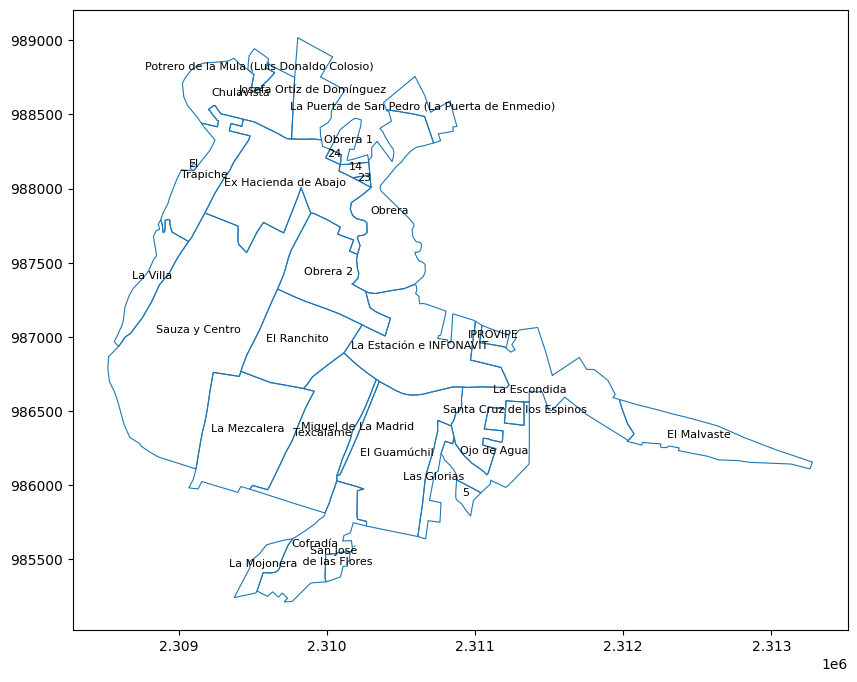

In [ ]:
# Visualizar el mapa de Jalisco con nombres de colonias
fig, ax = plt.subplots(figsize=(10, 10))
gdf_merged.boundary.plot(ax=ax, linewidth=0.8)  # Dibujar los límites del GeoDataFrame
gdf_merged.apply(lambda x: ax.annotate(text=x['NOMBRE_COLONIA'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), axis=1)

plt.show()

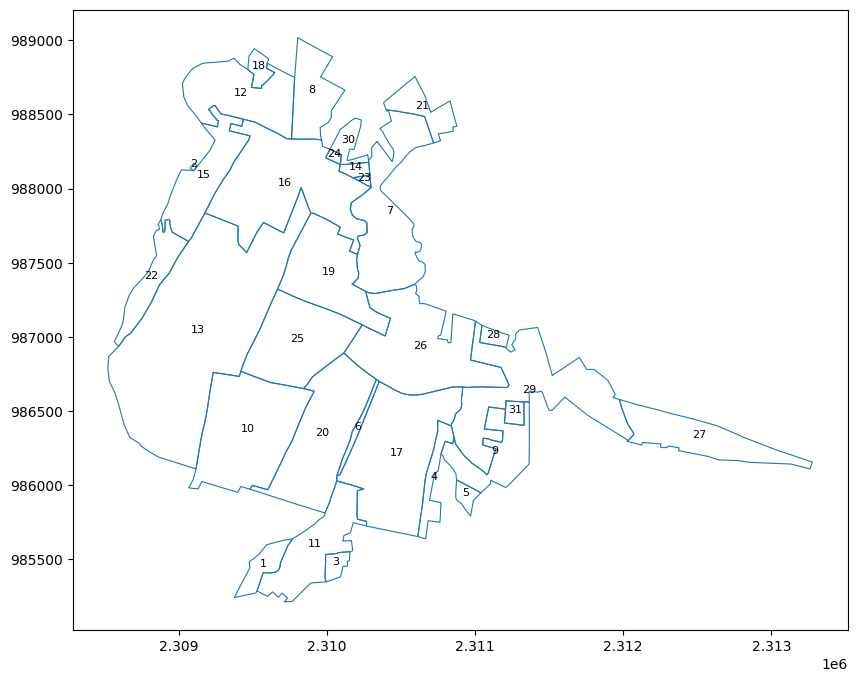

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_merged.boundary.plot(ax=ax, linewidth=0.8)  # Dibujar los límites del GeoDataFrame
gdf_merged.apply(lambda x: ax.annotate(text=x['IDENTIFICA'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), axis=1)

plt.show()

In [ ]:
# Corta las columnas CVEGEO para contener solo los primeros 12 caracteres
gdf_jalisco_fm['CVEGEO'] = gdf_jalisco_fm['CVEGEO'].str[:12]
gdf_merged['CVEGEO'] = gdf_merged['CVEGEO'].str[:12]

In [ ]:
gdf_merged

,IDENTIFICA,CVEGEO,geometry,NOMBRE_COLONIA
0,1,140940001045,"POLYGON ((2309527.978 985283.220, 2309520.687 ...",La Mojonera
1,2,140940001047,"POLYGON ((2309127.086 988152.953, 2309100.149 ...",El
2,3,140940001040,"POLYGON ((2310098.401 985402.499, 2310089.464 ...",San José \n de las Flores
3,4,140940001041,"POLYGON ((2310840.614 986396.880, 2310858.044 ...",Las Glorias
4,5,140940001053,"POLYGON ((2311039.775 985945.999, 2311039.368 ...",5
5,6,140940001033,"POLYGON ((2310333.403 986711.544, 2310353.622 ...",Miguel de La Madrid
6,7,140940001044,"POLYGON ((2310489.681 988519.486, 2310507.239 ...",Obrera
7,8,140940001056,"POLYGON ((2309804.303 989017.085, 2310037.052 ...",Josefa Ortíz de Domínguez
8,9,140940001049,"POLYGON ((2311365.997 986559.018, 2311366.000 ...",Ojo de Agua
9,10,140940001028,"POLYGON ((2309842.100 986649.668, 2309848.158 ...",La Mezcalera


In [ ]:
# Realiza la fusión basándote en la columna CVEGEO
gdf_merged_cp = pd.merge(gdf_merged, gdf_jalisco_fm[['CVEGEO', 'CP']], left_on=gdf_merged['CVEGEO'], right_on=gdf_jalisco_fm['CVEGEO'], how='left')

# Visualiza el resultado
print(gdf_merged_cp.head())

          key_0  IDENTIFICA      CVEGEO_x  \
0  140940001045           1  140940001045   
1  140940001045           1  140940001045   
2  140940001045           1  140940001045   
3  140940001045           1  140940001045   
4  140940001045           1  140940001045   

                                            geometry NOMBRE_COLONIA  \
0  POLYGON ((2309527.978 985283.220, 2309520.687 ...    La Mojonera   
1  POLYGON ((2309527.978 985283.220, 2309520.687 ...    La Mojonera   
2  POLYGON ((2309527.978 985283.220, 2309520.687 ...    La Mojonera   
3  POLYGON ((2309527.978 985283.220, 2309520.687 ...    La Mojonera   
4  POLYGON ((2309527.978 985283.220, 2309520.687 ...    La Mojonera   

       CVEGEO_y     CP  
0  140940001045  46403  
1  140940001045  46403  
2  140940001045  46403  
3  140940001045  46403  
4  140940001045  46403  


In [ ]:
gdf_merged_cp[['CVEGEO_x', 'CP']]

,CVEGEO_x,CP
0,140940001045,46403
1,140940001045,46403
2,140940001045,46403
3,140940001045,46403
4,140940001045,46403
...,...,...
2150,140940001046,46403
2151,140940001046,46403
2152,140940001046,46403
2153,140940001046,46403


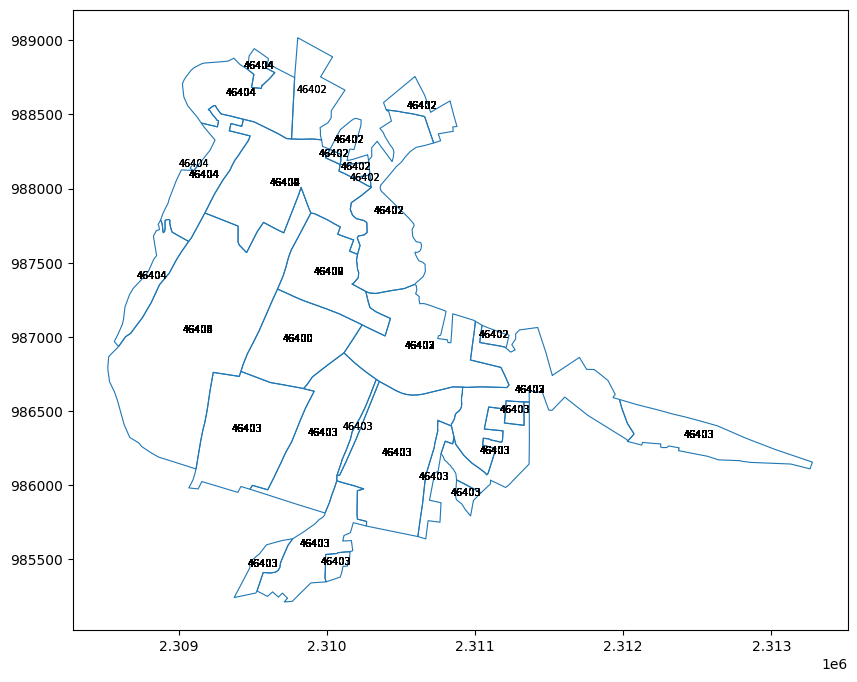

In [ ]:
# Visualizar el mapa de Jalisco

fig, ax = plt.subplots(figsize=(10, 10))
gdf_merged.boundary.plot(ax=ax, linewidth=0.8)  # Dibujar los límites del GeoDataFrame
gdf_merged_cp.apply(lambda x: ax.annotate(text=x['CP'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7), axis=1)

plt.show()

In [ ]:
gdf_merged_cp

,key_0,IDENTIFICA,CVEGEO_x,geometry,NOMBRE_COLONIA,CVEGEO_y,CP
0,140940001045,1,140940001045,"POLYGON ((2309527.978 985283.220, 2309520.687 ...",La Mojonera,140940001045,46403
1,140940001045,1,140940001045,"POLYGON ((2309527.978 985283.220, 2309520.687 ...",La Mojonera,140940001045,46403
2,140940001045,1,140940001045,"POLYGON ((2309527.978 985283.220, 2309520.687 ...",La Mojonera,140940001045,46403
3,140940001045,1,140940001045,"POLYGON ((2309527.978 985283.220, 2309520.687 ...",La Mojonera,140940001045,46403
4,140940001045,1,140940001045,"POLYGON ((2309527.978 985283.220, 2309520.687 ...",La Mojonera,140940001045,46403
...,...,...,...,...,...,...,...
2150,140940001046,31,140940001046,"POLYGON ((2311330.406 986559.326, 2311329.190 ...",Santa Cruz de los Espinos,140940001046,46403
2151,140940001046,31,140940001046,"POLYGON ((2311330.406 986559.326, 2311329.190 ...",Santa Cruz de los Espinos,140940001046,46403
2152,140940001046,31,140940001046,"POLYGON ((2311330.406 986559.326, 2311329.190 ...",Santa Cruz de los Espinos,140940001046,46403
2153,140940001046,31,140940001046,"POLYGON ((2311330.406 986559.326, 2311329.190 ...",Santa Cruz de los Espinos,140940001046,46403


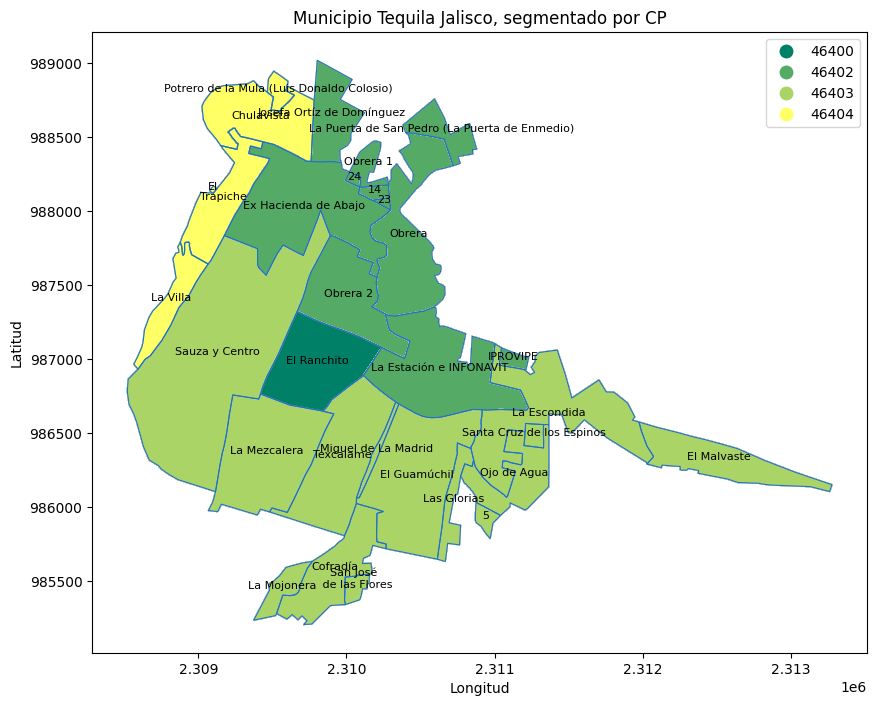

In [ ]:
# Suponiendo que 'codigo_postal' es el nombre de la columna que contiene el código postal
fig, ax = plt.subplots(figsize=(10, 10))
gdf_merged_cp.plot(column='CP', cmap='summer', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

gdf_merged.boundary.plot(ax=ax, linewidth=0.8)  # Dibujar los límites del GeoDataFrame

# Anotar el identificador en el centro de cada polígono
gdf_merged.apply(lambda x: ax.annotate(text=x['NOMBRE_COLONIA'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), axis=1)

# Añadir título y etiquetas
plt.title('Municipio Tequila Jalisco, segmentado por CP')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el mapa
plt.show()

Los CP colindantes son los contigüos?

In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia5 = []

# Iteramos sobre cada fila de SHF con el código postal deseado
for _, row_SHF in SHF_subset.iterrows():
    # Convertir el código postal a un entero
    zip_code_int = int(row_SHF['zip_code'])

    # Obtenemos el código postal actual y los códigos postales anteriores y posteriores
    #zip_codes = list(range(zip_code_int - 3, zip_code_int + 3))
    zip_codes = list(map(str, range(zip_code_int - 3, zip_code_int + 3)))

    # Filtramos SEPOMEX para que solo contenga filas con los códigos postales deseados
    SEPOMEX_cp_filtrado = SEPOMEX[SEPOMEX['d_codigo'].isin(zip_codes)]

    # Iteramos sobre todas las filas de SEPOMEX con los códigos postales deseados
    for _, row_SEPOMEX in SEPOMEX_cp_filtrado.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        distancia = calcular_distancia_levenshtein(row_SHF['colonia_sin_stopwords'], row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'])

        # Guardamos los resultados en la lista
        resultados_distancia5.append({
            'colonia_sin_stopwords_SHF': row_SHF['colonia_sin_stopwords'],
            'colonia_sin_stopwords_SEPOMEX': row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_levenshtein': distancia,
            'zip_code': row_SHF['zip_code'],
            'd_codigo': row_SEPOMEX['d_codigo']
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia5 = pd.DataFrame(resultados_distancia5)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia5)


          colonia_sin_stopwords_SHF colonia_sin_stopwords_SEPOMEX  \
0     cantera habitat integral funo                     altavista   
1     cantera habitat integral funo            praderas centinela   
2     cantera habitat integral funo            canteras centinela   
3     cantera habitat integral funo                   zoi canadas   
4     cantera habitat integral funo           real valdepenas dos   
...                             ...                           ...   
5603             valle encinos tres               arcos sebastian   
5604             valle encinos tres               casas sebastian   
5605             valle encinos tres                        miguel   
5606             valle encinos tres                 colinas roble   
5607             valle encinos tres                       encinos   

                 settlement_original           d_asenta_original  \
0     LA CANTERA HABITAT INTEGRAL F1       Altavista Residencial   
1     LA CANTERA HABITAT INTEGRAL F

In [ ]:
matriz_distancia5['distancia_levenshtein'].max()

54

In [ ]:
matriz_distancia5['distancia_levenshtein_normalizada'] = matriz_distancia5['distancia_levenshtein']/ matriz_distancia5['distancia_levenshtein'].max()

In [ ]:
matriz_distancia5['porcentaje_similitud'] = 1-matriz_distancia5['distancia_levenshtein_normalizada']

In [ ]:
matriz_distancia5.sort_values('distancia_levenshtein')[1045:1060]

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,zip_code,d_codigo,distancia_levenshtein_normalizada,porcentaje_similitud
902,barrio nuevo,recodo,BARRIO NUEVO,El Recodo,barrio nuevo,el recodo,9,45402,45400,0.166667,0.833333
1457,valle sol,martell valle,VALLE DEL SOL,Martell del Valle,valle del sol,martell del valle,9,45200,45200,0.166667,0.833333
1474,valle sol,callejon bosque,VALLE DEL SOL,Callejón del Bosque,valle del sol,callejon del bosque,9,45200,45200,0.166667,0.833333
533,colina real,lomas anita,COLINA REAL,Lomas de Santa Anita,colina real,lomas de santa anita,9,45641,45640,0.166667,0.833333
526,colina real,vista sur,COLINA REAL,Vista Sur Residencial,colina real,vista sur residencial,9,45641,45640,0.166667,0.833333
2377,loma real,villas cruz,LOMA REAL,Villas Cruz,loma real,villas cruz,9,45410,45410,0.166667,0.833333
918,barrio nuevo,mesa uno,BARRIO NUEVO,La Mesa I,barrio nuevo,la mesa uno,9,45402,45400,0.166667,0.833333
922,barrio nuevo,balcones sol,BARRIO NUEVO,Balcones Del Sol,barrio nuevo,balcones del sol,9,45402,45400,0.166667,0.833333
2123,valle dorado tres,valle encinos,VALLE DORADO III,Valle de Los Encinos,valle dorado tres,valle de los encinos,9,45653,45650,0.166667,0.833333
4829,dos loma dos,tulipanes,2 LA LOMA II,Tulipanes,dos la loma dos,tulipanes,9,45645,45647,0.166667,0.833333


In [ ]:
matriz_distancia_ordenada5 = matriz_distancia5.sort_values(by='distancia_levenshtein')
SHF_subset_menores_distancias_unicas5 = matriz_distancia_ordenada5.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas5

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_levenshtein,zip_code,d_codigo,distancia_levenshtein_normalizada,porcentaje_similitud
1631,miguel punta,miguel punta,SAN MIGUEL LA PUNTA,San Miguel de La Punta,san miguel la punta,san miguel de la punta,0,45425,45425,0.000000,1.000000
2230,monumental,monumental,MONUMENTAL,Monumental,monumental,monumental,0,44320,44320,0.000000,1.000000
2841,ciudad granja,ciudad granja,CIUDAD GRANJA,Ciudad Granja,ciudad granja,ciudad granja,0,45010,45010,0.000000,1.000000
1475,valle sol,valle sol,VALLE DEL SOL,Valle del Sol,valle del sol,valle del sol,0,45200,45200,0.000000,1.000000
4100,arcos guadalupe,arcos guadalupe,ARCOS DE GUADALUPE,Arcos de Guadalupe,arcos de guadalupe,arcos de guadalupe,0,45037,45037,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2,cantera habitat integral funo,canteras centinela,LA CANTERA HABITAT INTEGRAL F1,Canteras del Centinela,la cantera habitat integral funo,canteras del centinela,17,45134,45133,0.314815,0.685185
3563,fracc bosque real bosque real,real bosque,"""FRACC. BOSQUE REAL, CONDOMINIO BOSQUE REAL""",Real del Bosque,fracc bosque real condominio bosque real,real del bosque,18,45645,45645,0.333333,0.666667
490,desarrollo habitacional altavista unoa,marcelino garcia barragan,DESARROLLO HABITACIONAL ALTAVISTA 1-A,Marcelino Garcia Barragán,desarrollo habitacional altavista unoa,marcelino garcia barragan,26,45133,45134,0.481481,0.518519
5346,accion urbanistica denominada mirador bosque dos,mirador bosque,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,Mirador del Bosque,accion urbanistica denominada mirador del bosq...,mirador del bosque,34,45200,45200,0.629630,0.370370


In [ ]:
! pip install fuzzywuzzy

## Fuzzy ratio

Fuzzy ratio, proporciona un valor de similaridad entre dos string, por ejemplo entre Roma y roma el ratio es del 75 porque le hace falta un 25% de cambio para llegar a la otra palabra.

In [ ]:
import fuzzywuzzy
from fuzzywuzzy import fuzz

In [ ]:
help(fuzz)

Help on module fuzzywuzzy.fuzz in fuzzywuzzy:

NAME
    fuzzywuzzy.fuzz - # encoding: utf-8

FUNCTIONS
    QRatio(s1, s2, force_ascii=True, full_process=True)
        Quick ratio comparison between two strings.
        
        Runs full_process from utils on both strings
        Short circuits if either of the strings is empty after processing.
        
        :param s1:
        :param s2:
        :param force_ascii: Allow only ASCII characters (Default: True)
        :full_process: Process inputs, used here to avoid double processing in extract functions (Default: True)
        :return: similarity ratio
    
    UQRatio(s1, s2, full_process=True)
        Unicode quick ratio
        
        Calls QRatio with force_ascii set to False
        
        :param s1:
        :param s2:
        :return: similarity ratio
    
    UWRatio(s1, s2, full_process=True)
        Return a measure of the sequences' similarity between 0 and 100,
        using different algorithms. Same as WRatio but p

FUZZY CON CP ALEDAÑOS

In [ ]:
# Definir una función para calcular la distancia de Levenshtein
def calcular_distancia_fuzzy(str1, str2):
    return fuzz.partial_ratio(str1, str2)/100

In [ ]:
calcular_distancia_fuzzy('amor', 'morir')

0.75

In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia6 = []

# Iteramos sobre cada fila de SHF con el código postal deseado
for _, row_SHF in SHF_subset.iterrows():
    # Convertir el código postal a un entero
    zip_code_int = int(row_SHF['zip_code'])

    # Obtenemos el código postal actual y los códigos postales anteriores y posteriores
    #zip_codes = list(range(zip_code_int - 3, zip_code_int + 3))
    zip_codes = list(map(str, range(zip_code_int - 3, zip_code_int + 3)))

    # Filtramos SEPOMEX para que solo contenga filas con los códigos postales deseados
    SEPOMEX_cp_filtrado = SEPOMEX[SEPOMEX['d_codigo'].isin(zip_codes)]

    # Iteramos sobre todas las filas de SEPOMEX con los códigos postales deseados
    for _, row_SEPOMEX in SEPOMEX_cp_filtrado.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        distancia = calcular_distancia_fuzzy(row_SHF['colonia_sin_stopwords'], row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'])

        # Guardamos los resultados en la lista
        resultados_distancia6.append({
            'colonia_sin_stopwords_SHF': row_SHF['colonia_sin_stopwords'],
            'colonia_sin_stopwords_SEPOMEX': row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_fuzzy_normalizada': distancia,
            'zip_code': row_SHF['zip_code'],
            'd_codigo': row_SEPOMEX['d_codigo']
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia6 = pd.DataFrame(resultados_distancia6)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia6)


          colonia_sin_stopwords_SHF colonia_sin_stopwords_SEPOMEX  \
0     cantera habitat integral funo                     altavista   
1     cantera habitat integral funo            praderas centinela   
2     cantera habitat integral funo            canteras centinela   
3     cantera habitat integral funo                   zoi canadas   
4     cantera habitat integral funo           real valdepenas dos   
...                             ...                           ...   
5603             valle encinos tres               arcos sebastian   
5604             valle encinos tres               casas sebastian   
5605             valle encinos tres                        miguel   
5606             valle encinos tres                 colinas roble   
5607             valle encinos tres                       encinos   

                 settlement_original           d_asenta_original  \
0     LA CANTERA HABITAT INTEGRAL F1       Altavista Residencial   
1     LA CANTERA HABITAT INTEGRAL F

In [ ]:
matriz_distancia6['distancia_fuzzy_normalizada'].max()

1.0

In [ ]:
matriz_distancia6['distancia_fuzzy'] = (1-matriz_distancia6['distancia_fuzzy_normalizada'])*100

In [ ]:
matriz_distancia6.sort_values('distancia_fuzzy')[0:10]

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_fuzzy_normalizada,zip_code,d_codigo,distancia_fuzzy
5607,valle encinos tres,encinos,VALLE DE LOS ENCINOS III,Los Encinos,valle de los encinos tres,los encinos,1.0,45650,45650,0.0
3107,loma bonita,loma bonita ejidal,Fraccionamiento Residencial Loma Bonita,Loma Bonita Ejidal,fraccionamiento residencial loma bonita,loma bonita ejidal,1.0,45088,45085,0.0
3106,valle encinos cinco,encinos,VALLE DE LOS ENCINOS ETAPA 5,Los Encinos,valle de los encinos etapa cinco,los encinos,1.0,45650,45650,0.0
3075,valle encinos cinco,valle encinos,VALLE DE LOS ENCINOS ETAPA 5,Valle de Los Encinos,valle de los encinos etapa cinco,valle de los encinos,1.0,45650,45650,0.0
3058,real sol,real sol,REAL DEL SOL,Real del Sol,real del sol,real del sol,1.0,45654,45654,0.0
2970,valle encinos seis,encinos,"""VALLE DE LOS ENCINOS, ETAPA 6""",Los Encinos,valle de los encinos etapa seis,los encinos,1.0,45653,45650,0.0
2939,valle encinos seis,valle encinos,"""VALLE DE LOS ENCINOS, ETAPA 6""",Valle de Los Encinos,valle de los encinos etapa seis,valle de los encinos,1.0,45653,45650,0.0
2889,valle tonantzin dos,valle tonantzin,VALLE DE TONANTZIN II,Valle de Tonantzin,valle de tonantzin dos,valle de tonantzin,1.0,45410,45410,0.0
2841,ciudad granja,ciudad granja,CIUDAD GRANJA,Ciudad Granja,ciudad granja,ciudad granja,1.0,45010,45010,0.0
2831,campestre coto niagara,campestre,Fraccionamiento El Campestre Residencial Condo...,El Campestre,fraccionamiento el campestre residencial condo...,el campestre,1.0,45221,45221,0.0


In [ ]:
matriz_distancia_ordenada6 = matriz_distancia6.sort_values(by='distancia_fuzzy')
SHF_subset_menores_distancias_unicas6 = matriz_distancia_ordenada6.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas6

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_fuzzy_normalizada,zip_code,d_codigo,distancia_fuzzy
5607,valle encinos tres,encinos,VALLE DE LOS ENCINOS III,Los Encinos,valle de los encinos tres,los encinos,1.00,45650,45650,0.0
3107,loma bonita,loma bonita ejidal,Fraccionamiento Residencial Loma Bonita,Loma Bonita Ejidal,fraccionamiento residencial loma bonita,loma bonita ejidal,1.00,45088,45085,0.0
3106,valle encinos cinco,encinos,VALLE DE LOS ENCINOS ETAPA 5,Los Encinos,valle de los encinos etapa cinco,los encinos,1.00,45650,45650,0.0
3058,real sol,real sol,REAL DEL SOL,Real del Sol,real del sol,real del sol,1.00,45654,45654,0.0
2970,valle encinos seis,encinos,"""VALLE DE LOS ENCINOS, ETAPA 6""",Los Encinos,valle de los encinos etapa seis,los encinos,1.00,45653,45650,0.0
...,...,...,...,...,...,...,...,...,...,...
1733,cumbres cuatro,larios,CUMBRES 4 ETAPA,Larios,cumbres cuatro etapa,larios,0.60,45640,45640,40.0
1663,tossa,coto arezzo,Fraccionamiento Residencial Tossa,Coto Arezzo,fraccionamiento residencial tossa,coto arezzo,0.60,45602,45601,40.0
3446,real navarra,arena,REAL DE NAVARRA,La Arena,real de navarra,la arena,0.60,45640,45638,40.0
2668,colibri cuatro,cortijo,EL COLIBRI ETAPA 4,El Cortijo,el colibri etapa cuatro,el cortijo,0.57,45641,45640,43.0


Lo mismo sobre todo SEPOMEX, fuzzy y sin stopwords

In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia7 = []

# Iteramos sobre cada fila de SHF
for _, row_SHF in SHF_subset.iterrows():
    # Iteramos sobre todas las filas de SEPOMEX
    for _, row_SEPOMEX in SEPOMEX.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        #distancia = calcular_distancia_fuzzy(row_SHF['colonia_sin_stopwords'], row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'])
        distancia = calcular_distancia_fuzzy(str(row_SHF['colonia_sin_stopwords']).replace("nan", ""), str(row_SEPOMEX['colonia_sin_stopwords_SEPOMEX']).replace("nan", ""))

        # Guardamos los resultados en la lista
        resultados_distancia7.append({
            'colonia_sin_stopwords_SHF': row_SHF['colonia_sin_stopwords'],
            'colonia_sin_stopwords_SEPOMEX': row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_fuzzy_normalizada': distancia,
            'zip_code': row_SHF['zip_code'],
            'd_codigo': row_SEPOMEX['d_codigo']
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia7 = pd.DataFrame(resultados_distancia7)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia7)

            colonia_sin_stopwords_SHF colonia_sin_stopwords_SEPOMEX  \
0       cantera habitat integral funo            guadalajara centro   
1       cantera habitat integral funo             vallarta poniente   
2       cantera habitat integral funo                arcos vallarta   
3       cantera habitat integral funo                         arcos   
4       cantera habitat integral funo                 obrera centro   
...                               ...                           ...   
607195             valle encinos tres         villa morelos carrizo   
607196             valle encinos tres                      platanos   
607197             valle encinos tres                        zipoco   
607198             valle encinos tres                       parotas   
607199             valle encinos tres                  abasolo casa   

                   settlement_original           d_asenta_original  \
0       LA CANTERA HABITAT INTEGRAL F1          Guadalajara Centro   
1      

In [ ]:
matriz_distancia7['distancia_fuzzy_normalizada'].max()

1.0

In [ ]:
matriz_distancia7['distancia_fuzzy'] = (1-matriz_distancia7['distancia_fuzzy_normalizada'])*100

In [ ]:
matriz_distancia7.sort_values('distancia_fuzzy')[0:10]

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_fuzzy_normalizada,zip_code,d_codigo,distancia_fuzzy
569435,accion urbanistica denominada mirador bosque dos,mina,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,La Mina,accion urbanistica denominada mirador del bosq...,la mina,1.0,45200,48280,0.0
294207,huertas,huertas,LAS HUERTAS,Las Huertas,las huertas,las huertas,1.0,45589,46288,0.0
404057,p sta cruz valle cuatro,cruz,P. STA. CRUZ DEL VALLE IV,La Cruz,p sta cruz del valle cuatro,la cruz,1.0,45615,47202,0.0
341956,arenales tapatios,arena,ARENALES TAPATIOS,La Arena,arenales tapatios,la arena,1.0,45066,45638,0.0
256921,villas,villas tapatio,LAS VILLAS,Villas del Tapatío,las villas,villas del tapatio,1.0,45655,45629,0.0
293905,huertas,balneario huertas,LAS HUERTAS,Balneario Las Huertas,las huertas,balneario las huertas,1.0,45589,45930,0.0
257009,villas,villas,LAS VILLAS,Las Villas,las villas,las villas,1.0,45655,45643,0.0
427503,arcos zapopan,arco,Fraccionamiento Arcos de Zapopan,El Arco,fraccionamiento arcos de zapopan,el arco,1.0,45130,45944,0.0
404191,p sta cruz valle cuatro,cruz,P. STA. CRUZ DEL VALLE IV,La Cruz,p sta cruz del valle cuatro,la cruz,1.0,45615,47254,0.0
293397,huertas,huertas productivas jalisco,LAS HUERTAS,Huertas Productivas de Jalisco,las huertas,huertas productivas de jalisco,1.0,45589,45640,0.0


In [ ]:
matriz_distancia_ordenada7 = matriz_distancia7.sort_values(by='distancia_fuzzy')
SHF_subset_menores_distancias_unicas7 = matriz_distancia_ordenada7.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas7

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_fuzzy_normalizada,zip_code,d_codigo,distancia_fuzzy
569435,accion urbanistica denominada mirador bosque dos,mina,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,La Mina,accion urbanistica denominada mirador del bosq...,la mina,1.00,45200,48280,0.0
294207,huertas,huertas,LAS HUERTAS,Las Huertas,las huertas,las huertas,1.00,45589,46288,0.0
404057,p sta cruz valle cuatro,cruz,P. STA. CRUZ DEL VALLE IV,La Cruz,p sta cruz del valle cuatro,la cruz,1.00,45615,47202,0.0
341956,arenales tapatios,arena,ARENALES TAPATIOS,La Arena,arenales tapatios,la arena,1.00,45066,45638,0.0
256921,villas,villas tapatio,LAS VILLAS,Villas del Tapatío,las villas,villas del tapatio,1.00,45655,45629,0.0
...,...,...,...,...,...,...,...,...,...,...
498677,portal valle,valle,PORTAL DEL VALLE,Residencial del Valle,portal del valle,residencial del valle,1.00,45589,45136,0.0
560209,parque royal,parque,PARQUE ROYAL,Residencial del Parque,parque royal,residencial del parque,1.00,45019,45430,0.0
207183,coto llave almendros,almendros,Coto La Llave y/o Los Almendros,Los Almendros,coto la llave yo los almendros,los almendros,1.00,45615,45133,0.0
178069,nordika,hacienda noria,NORDIKA RESIDENCIAL,Hacienda La Noria,nordika residencial,hacienda la noria,0.83,45134,45641,17.0


# Fuzzy ratio sin stoprwords sin CP colindantes

In [ ]:
# Definir una función para calcular la distancia de Levenshtein
def calcular_distancia_fuzzy(str1, str2):
    return fuzz.ratio(str1, str2)/100

In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia7 = []

# Iteramos sobre cada fila de SHF
for _, row_SHF in SHF_subset.iterrows():
    # Iteramos sobre todas las filas de SEPOMEX
    for _, row_SEPOMEX in SEPOMEX.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        #distancia = calcular_distancia_fuzzy(row_SHF['colonia_sin_stopwords'], row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'])
        distancia = calcular_distancia_fuzzy(str(row_SHF['colonia_sin_stopwords']).replace("nan", ""), str(row_SEPOMEX['colonia_sin_stopwords_SEPOMEX']).replace("nan", ""))

        # Guardamos los resultados en la lista
        resultados_distancia7.append({
            'colonia_sin_stopwords_SHF': row_SHF['colonia_sin_stopwords'],
            'colonia_sin_stopwords_SEPOMEX': row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_fuzzy_normalizada': distancia,
            'zip_code': row_SHF['zip_code'],
            'd_codigo': row_SEPOMEX['d_codigo']
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia7 = pd.DataFrame(resultados_distancia7)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia7)

            colonia_sin_stopwords_SHF colonia_sin_stopwords_SEPOMEX  \
0       cantera habitat integral funo            guadalajara centro   
1       cantera habitat integral funo             vallarta poniente   
2       cantera habitat integral funo                arcos vallarta   
3       cantera habitat integral funo                         arcos   
4       cantera habitat integral funo                 obrera centro   
...                               ...                           ...   
607195             valle encinos tres         villa morelos carrizo   
607196             valle encinos tres                      platanos   
607197             valle encinos tres                        zipoco   
607198             valle encinos tres                       parotas   
607199             valle encinos tres                  abasolo casa   

                   settlement_original           d_asenta_original  \
0       LA CANTERA HABITAT INTEGRAL F1          Guadalajara Centro   
1      

In [ ]:
matriz_distancia7['distancia_fuzzy_normalizada'].max()

1.0

In [ ]:
matriz_distancia7['distancia_fuzzy'] = (1-matriz_distancia7['distancia_fuzzy_normalizada'])*100

In [ ]:
matriz_distancia_ordenada7 = matriz_distancia7.sort_values(by='distancia_fuzzy')
SHF_subset_menores_distancias_unicas7 = matriz_distancia_ordenada7.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas7

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_fuzzy_normalizada,zip_code,d_codigo,distancia_fuzzy
110848,jardines hacienda,jardines hacienda,JARDINES DE LA HACIENDA E,Jardines de La Hacienda,jardines de la hacienda e,jardines de la hacienda,1.00,45653,45428,0.0
259572,villas,villas,LAS VILLAS,Las Villas,las villas,las villas,1.00,45655,47936,0.0
378549,chirimoyo,chirimoyo,EL CHIRIMOYO,El Chirimoyo,el chirimoyo,el chirimoyo,1.00,45650,45650,0.0
323958,real sol,real sol,REAL DEL SOL,Real del Sol,real del sol,real del sol,1.00,45654,45654,0.0
576936,belisario dominguez,belisario dominguez,BELISARIO DOMINGUEZ,Belisario Domínguez,belisario dominguez,belisario dominguez,1.00,44320,44329,0.0
...,...,...,...,...,...,...,...,...,...,...
411741,chulavista catorce catorce,linda vista oceano,CHULAVISTA 14 CATORCE ETAPA,Linda Vista Océano,chulavista catorce catorce etapa,linda vista oceano,0.59,45653,48344,41.0
219022,parques colon parques colon cuatro cuatro manz...,parques colon seccion dos,PARQUES DE COLON CONDOMINIO PARQUES DE COLON 4...,Parques de Colón Sección 2,parques de colon condominio parques de colon c...,parques de colon seccion dos,0.56,45608,44987,44.0
35153,desarrollo habitacional altavista unoa,ampliacion vista dorada,DESARROLLO HABITACIONAL ALTAVISTA 1-A,Ampliación Vista Dorada,desarrollo habitacional altavista unoa,ampliacion vista dorada,0.56,45133,48290,44.0
396727,fracc bosque real bosque real,bosque real,"""FRACC. BOSQUE REAL, CONDOMINIO BOSQUE REAL""",Bosque Real,fracc bosque real condominio bosque real,bosque real,0.55,45645,45645,45.0


# Fuzzy ratio sin stopword  y con CP aledaños

In [ ]:
# Inicializamos una lista para almacenar los resultados
resultados_distancia6 = []

# Iteramos sobre cada fila de SHF con el código postal deseado
for _, row_SHF in SHF_subset.iterrows():
    # Convertir el código postal a un entero
    zip_code_int = int(row_SHF['zip_code'])

    # Obtenemos el código postal actual y los códigos postales anteriores y posteriores
    #zip_codes = list(range(zip_code_int - 3, zip_code_int + 3))
    zip_codes = list(map(str, range(zip_code_int - 3, zip_code_int + 3)))

    # Filtramos SEPOMEX para que solo contenga filas con los códigos postales deseados
    SEPOMEX_cp_filtrado = SEPOMEX[SEPOMEX['d_codigo'].isin(zip_codes)]

    # Iteramos sobre todas las filas de SEPOMEX con los códigos postales deseados
    for _, row_SEPOMEX in SEPOMEX_cp_filtrado.iterrows():
        # Calculamos la distancia de Levenshtein entre las colonias
        distancia = calcular_distancia_fuzzy(row_SHF['colonia_sin_stopwords'], row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'])

        # Guardamos los resultados en la lista
        resultados_distancia6.append({
            'colonia_sin_stopwords_SHF': row_SHF['colonia_sin_stopwords'],
            'colonia_sin_stopwords_SEPOMEX': row_SEPOMEX['colonia_sin_stopwords_SEPOMEX'],
            'settlement_original': row_SHF['settlement_original'],
            'd_asenta_original': row_SEPOMEX['d_asenta_original'],
            'settlement_SHF': row_SHF['settlement'],
            'd_asenta_SEPOMEX': row_SEPOMEX['d_asenta'],
            'distancia_fuzzy_normalizada': distancia,
            'zip_code': row_SHF['zip_code'],
            'd_codigo': row_SEPOMEX['d_codigo']
        })

# Convertimos la lista de resultados a DataFrame
matriz_distancia6 = pd.DataFrame(resultados_distancia6)

# Mostramos el DataFrame de la matriz de distancia
print(matriz_distancia6)


          colonia_sin_stopwords_SHF colonia_sin_stopwords_SEPOMEX  \
0     cantera habitat integral funo                     altavista   
1     cantera habitat integral funo            praderas centinela   
2     cantera habitat integral funo            canteras centinela   
3     cantera habitat integral funo                   zoi canadas   
4     cantera habitat integral funo           real valdepenas dos   
...                             ...                           ...   
5603             valle encinos tres               arcos sebastian   
5604             valle encinos tres               casas sebastian   
5605             valle encinos tres                        miguel   
5606             valle encinos tres                 colinas roble   
5607             valle encinos tres                       encinos   

                 settlement_original           d_asenta_original  \
0     LA CANTERA HABITAT INTEGRAL F1       Altavista Residencial   
1     LA CANTERA HABITAT INTEGRAL F

In [ ]:
matriz_distancia6['distancia_fuzzy_normalizada'].max()

1.0

In [ ]:
matriz_distancia6['distancia_fuzzy'] = (1-matriz_distancia6['distancia_fuzzy_normalizada'])*100

In [ ]:
matriz_distancia_ordenada6 = matriz_distancia6.sort_values(by='distancia_fuzzy')
SHF_subset_menores_distancias_unicas6 = matriz_distancia_ordenada6.drop_duplicates(subset='settlement_SHF')
SHF_subset_menores_distancias_unicas6

,colonia_sin_stopwords_SHF,colonia_sin_stopwords_SEPOMEX,settlement_original,d_asenta_original,settlement_SHF,d_asenta_SEPOMEX,distancia_fuzzy_normalizada,zip_code,d_codigo,distancia_fuzzy
3423,tulipanes,tulipanes,TULIPANES,Tulipanes,tulipanes,tulipanes,1.00,45647,45647,0.0
1418,jacarandas,jacarandas,Condominio Jacarandas,Jacarandas,condominio jacarandas,jacarandas,1.00,45110,45110,0.0
5374,valle real,valle real,Valle Real,Valle Real,valle real,valle real,1.00,45019,45019,0.0
4100,arcos guadalupe,arcos guadalupe,ARCOS DE GUADALUPE,Arcos de Guadalupe,arcos de guadalupe,arcos de guadalupe,1.00,45037,45037,0.0
2814,huertas,huertas,LAS HUERTAS,Las Huertas,las huertas,las huertas,1.00,45589,45589,0.0
...,...,...,...,...,...,...,...,...,...,...
4665,luces dos dos romano,valle dorado,LAS LUCES II DOS ROMANO,Valle Dorado,las luces dos dos romano,valle dorado,0.50,45653,45653,50.0
5346,accion urbanistica denominada mirador bosque dos,mirador bosque,ACCION URBANISTICA DENOMINADA MIRADOR DEL BOSQ...,Mirador del Bosque,accion urbanistica denominada mirador del bosq...,mirador del bosque,0.45,45200,45200,55.0
490,desarrollo habitacional altavista unoa,marcelino garcia barragan,DESARROLLO HABITACIONAL ALTAVISTA 1-A,Marcelino Garcia Barragán,desarrollo habitacional altavista unoa,marcelino garcia barragan,0.44,45133,45134,56.0
1689,tossa,iteso,Fraccionamiento Residencial Tossa,ITESO,fraccionamiento residencial tossa,iteso,0.40,45602,45604,60.0


In [ ]:
matriz_distancia7.to_csv('matriz_distancia7.csv', index=False)
SHF_subset_menores_distancias_unicas7.to_csv('SHF_subset_menores_distancias_unicas7.csv', index=False)